### Note
 - This note book is used for the analyze the metrics for designs with different inverse folding models


In [1]:
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sys
import pandas as pd
import json
from pathlib import Path
import abnumber
from collections import Counter

REPO_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)


from scripts.data_processing import Inverse_Folding_Design, Batch_Designs, Dataset, Exps
from scripts.utils import get_cdr_residue_idx_list, calculate_seq_identity, fasta2seq, calculate_seq_similarity_blosum62, parse_blosum62, restype_1to3, get_sequence_by_biopython
aa_list = restype_1to3.keys()
BLOSUM62_MATRIX = parse_blosum62('../data/resources/BLOSUM62.txt')



The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/nfs_beijing/kubeflow-user/yifan/.conda/envs/biomappd_yifan/lib/python3.10/site-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(


In [75]:
df_pos_all = pd.read_csv("../data/processed/df_pos_all.csv", index_col=0)
df_pdb_all = pd.read_csv("../data/processed/df_pdb_all.csv", index_col=0)
df_info_all = pd.read_csv("../data/processed/df_info_all.csv", index_col=0)

df_skempi = pd.read_csv("../data/resources/skempi_v2.csv", sep=';')

EXP_INFO_JSON = "../data/metadata.json"


df_fab_info = pd.read_csv("../data/resources/df_fab_info.csv", index_col=0)
df_vhh_info = pd.read_csv("../data/resources/df_vhh_info.csv", index_col=0)

## Define exps

In [70]:
exps = Exps(df_fab= df_fab_info, df_vhh= df_vhh_info, exp_info_json=EXP_INFO_JSON)
# exps.collect_results()


Got the following exp_info
design id: lm_design_vanilla-fab-fullseq
{'results_dir': '../data/design_raw/lm_design_fab_0916_full_seq', 'method': 'lm_design_vanilla', 'antibody_type': 'fab', 'info': 'full antibody seq design using lm_design vanilla on Github, with T=0.2', 'NAME': 'LM Design'}
design id: lm_design_api-fab-fullseq_T02
{'results_dir': '../data/design_raw/lm_design_fab_0913_full_seq', 'method': 'lm_design_biomap', 'antibody_type': 'fab', 'info': 'full antibody seq design using BioMap api, with T=0.2', 'NAME': 'LM Design'}
design id: lm_design_api_noAG-fab-fullseq
{'results_dir': '../data/design_raw/lm_design_fab_0919_noAgChain', 'method': 'lm_design_biomap', 'antibody_type': 'fab', 'info': 'full antibody seq design w/o ag chain in pdb complex using BioMap api', 'NAME': 'LM Design'}
design id: antifold-fab-fullseq
{'results_dir': '../data/design_raw/AntiFold_Batch_fab_0903', 'method': 'antifold', 'antibody_type': 'fab', 'info': 'antifold github version', 'NAME': 'AntiFold'}
d

### Save and load exps

In [4]:
import pickle

pkl_dir = "../data/processed/exps_pickle"
version = '250217'

version_path = Path(pkl_dir)/Path(f"{version}.pkl")
# print(f"saving to {version_path}")
# with open(version_path, 'wb') as f:
#     pickle.dump(exps, f)


In [8]:
# load from saved
with open(version_path, 'rb') as f:
    exps = pickle.load(f)

### Defination

In [71]:
class Design_methods:
    design_methods_fab = ['esm_if-fab-fullseq', 'mpnn-fab-fullseq', 'lm_design_vanilla-fab-fullseq', 'antifold-fab-fullseq', 'abmpnn-fab-fullseq']
    design_methods_fab_1 = ['esm_if-fab-fullseq', 'mpnn-fab-fullseq', 'lm_design_vanilla-fab-fullseq', 'antifold-fab-fullseq']
    design_methods_vhh = ['esm_if-vhh-fullseq', 'mpnn-vhh-fullseq', 'lm_design_vanilla-vhh-fullseq', 'antifold-vhh-fullseq', 'abmpnn-vhh-fullseq']
    design_methods_vhh_1 = ['esm_if-vhh-fullseq', 'mpnn-vhh-fullseq', 'lm_design_vanilla-vhh-fullseq', 'antifold-vhh-fullseq']
    design_methods_lm_fab_compare = ['lm_design_api-fab-fullseq_T07', 'lm_design_api-fab-fullseq_T02', 'lm_design_vanilla-fab-fullseq', 'lm_design_api-fab-noag']
    design_methods_lm_fab_compare1 = ['lm_design_api-fab-fullseq_T07', 'lm_design_api-fab-noag']

    design_methods_lm_vhh_compare = ['lm_design_api-vhh-fullseq_T07', 'lm_design_api-vhh-fullseq_T02', 'lm_design_vanilla-vhh-fullseq', 'lm_design_api-vhh-cdronly','lm_design_api-vhh-noag']
    antifold_ag_noag = ['antifold-fab-fullseq', 'antifold_noAG-fab-fullseq']
    antifold_relax = ['antifold-fab-fullseq', 'antifold_relaxed-fab-fullseq']
    lm_design_ag_noag = ['lm_design_api-fab-fullseq_T02', 'lm_design_api_noAG-fab-fullseq']
    esm_if_ag_noag = ['esm_if-fab-fullseq', 'esm_if_noAG-fab-fullseq']
    esm_if_relax = ['esm_if-fab-fullseq', 'esm_if_relaxed-fab-fullseq']
    ag_noag = ['lm_design_api-fab-fullseq_T02', 'lm_design_api_noAG-fab-fullseq', 'esm_if-fab-fullseq', 'esm_if_noAG-fab-fullseq', 'antifold-fab-fullseq', 'antifold_noAG-fab-fullseq', 'mpnn-fab-fullseq', 'mpnn_noAG-fab-fullseq']


class Metrics:
   full = ['identity-H_CDR1', 'identity-H_CDR2', 'identity-H_CDR3',
        'identity-L_CDR1', 'identity-L_CDR2', 'identity-L_CDR3',
        'similarity_B62-H_CDR1', 'similarity_B62-H_CDR2', 'similarity_B62-H_CDR3',
        'similarity_B62-L_CDR1', 'similarity_B62-L_CDR2', 'similarity_B62-L_CDR3', 
        'identity-cdr_concat', 'similarity_B62-cdr_concat']
   full_recovery = ['identity-H_CDR1', 'identity-H_CDR2', 'identity-H_CDR3',
       'identity-L_CDR1', 'identity-L_CDR2', 'identity-L_CDR3']

   vhh = ['identity-H_CDR1', 'identity-H_CDR2', 'identity-H_CDR3',
       'similarity_B62-H_CDR1', 'similarity_B62-H_CDR2',
       'similarity_B62-H_CDR3', 'identity-cdr_concat', 'similarity_B62-cdr_concat']
   vhh_recovery = ['identity-H_CDR1', 'identity-H_CDR2', 'identity-H_CDR3']
   vhh_similarity = ['similarity_B62-H_CDR1', 'similarity_B62-H_CDR2', 'similarity_B62-H_CDR3', 'similarity_B62-cdr_concat']

   full_simple = ['identity-H_CDR3',
        'similarity_B62-H_CDR3',
        'identity-cdr_concat',
        'similarity_B62-cdr_concat']


# for converting labels to more formal format

metric_map = {'identity-cdr_concat': 'Recovery for concatenated CDRs',
 'similarity_B62-cdr_concat': 'BLOSM62 similarity for concatenated CDRs',
 'identity-H_CDR1': 'Recovery for H1',
 'identity-H_CDR2': 'Recovery for H2',
 'identity-H_CDR3': 'Recovery for H3',
 'similarity_B62-H_CDR1': 'BLOSM62 similarity for H1',
 'similarity_B62-H_CDR2': 'BLOSM62 similarity for H2',
 'similarity_B62-H_CDR3': 'BLOSM62 similarity for H3',
 'identity-L_CDR1': 'Recovery for L1',
 'identity-L_CDR2': 'Recovery for L2',
 'identity-L_CDR3': 'Recovery for L3',
 'similarity_B62-L_CDR1': 'BLOSM62 similarity for L1',
 'similarity_B62-L_CDR2': 'BLOSM62 similarity for L2',
 'similarity_B62-L_CDR3': 'BLOSM62 similarity for L3'}

metric_map2 = {'identity-cdr_concat': 'Concatenated CDRs',
 'similarity_B62-cdr_concat': 'Concatenated CDRs',
 'identity-H_CDR1': 'H1',
 'identity-H_CDR2': 'H2',
 'identity-H_CDR3': 'H3',
 'similarity_B62-H_CDR1': 'H1',
 'similarity_B62-H_CDR2': 'H2',
 'similarity_B62-H_CDR3': 'H3',
 'identity-L_CDR1': 'L1',
 'identity-L_CDR2': 'L2',
 'identity-L_CDR3': 'L3',
 'similarity_B62-L_CDR1': 'L1',
 'similarity_B62-L_CDR2': 'L2',
 'similarity_B62-L_CDR3': 'L3'}

metric_map3 = {'identity-cdr_concat': 'Recovery Rate for concatenated CDRs',
 'similarity_B62-cdr_concat': 'BLOSM62 Similarity for concatenated CDRs',
 'identity-H_CDR1': 'Recovery Rate for H1',
 'identity-H_CDR2': 'Recovery Rate for H2',
 'identity-H_CDR3': 'Recovery Rate for H3',
 'similarity_B62-H_CDR1': 'BLOSM62 Similarity for H1',
 'similarity_B62-H_CDR2': 'BLOSM62 Similarity for H2',
 'similarity_B62-H_CDR3': 'BLOSM62 Similarity for H3',
 'identity-L_CDR1': 'Recovery Rate for L1',
 'identity-L_CDR2': 'Recovery Rate for L2',
 'identity-L_CDR3': 'Recovery Rate for L3',
 'similarity_B62-L_CDR1': 'BLOSM62 similarity for L1',
 'similarity_B62-L_CDR2': 'BLOSM62 similarity for L2',
 'similarity_B62-L_CDR3': 'BLOSM62 similarity for L3'}

antibody_type_map = {
    'fab': 'Fab',
    'vhh': 'VHH'
} 

## confusion matrix

In [7]:
def get_df_pos_group(df_pos):
    if 'task_id' in df_pos.columns:
        _df_pos = df_pos.drop(columns=['task_id'])
    df_pos_group = _df_pos.groupby('wt_aa').agg('sum').reset_index()
    
    if 'X' in df_pos_group.columns:
        df_pos_group = df_pos_group.drop(columns=['X'])
    if '-' in df_pos_group.columns:
        df_pos_group = df_pos_group.drop(columns=['-'])
    df_pos_group['wt_aa'] = pd.Categorical(df_pos_group['wt_aa'], categories=list(restype_1to3.keys()), ordered=True)
    df_pos_group = df_pos_group.sort_values('wt_aa')
    df_pos_group.index = df_pos_group['wt_aa']

    df_pos_group = df_pos_group.iloc[:, 4:]
    df_pos_gp = df_pos_group.apply(lambda x: x / x.sum(), axis=1)

    return df_pos_gp


def plot_heat_map(df_pos_all, methods):
    for i, k in enumerate(methods):
        print(f"ploting for {k}")
        df_pos = df_pos_all[df_pos_all['task_id'] == k]

        df_pos_gp = get_df_pos_group(df_pos)
        plt.figure(figsize=(15*0.6, 12*0.6))
        ax = sns.heatmap(df_pos_gp, annot=False, fmt=".2f", linewidth=.5, cmap="Blues") # cmap="BuPu" cmap="coolwarm"
        ax.set_title(f"{exps.exp_info[k]['NAME']} for {antibody_type_map[exps.exp_info[k]['antibody_type']]} design", y=1.04)
        ax.set_ylabel("Amino acid residue type")
        plt.text(-1, -1, "ABCD"[i], fontsize=14, fontweight='bold')
        
        plt.show()

 

ploting for esm_if-fab-fullseq


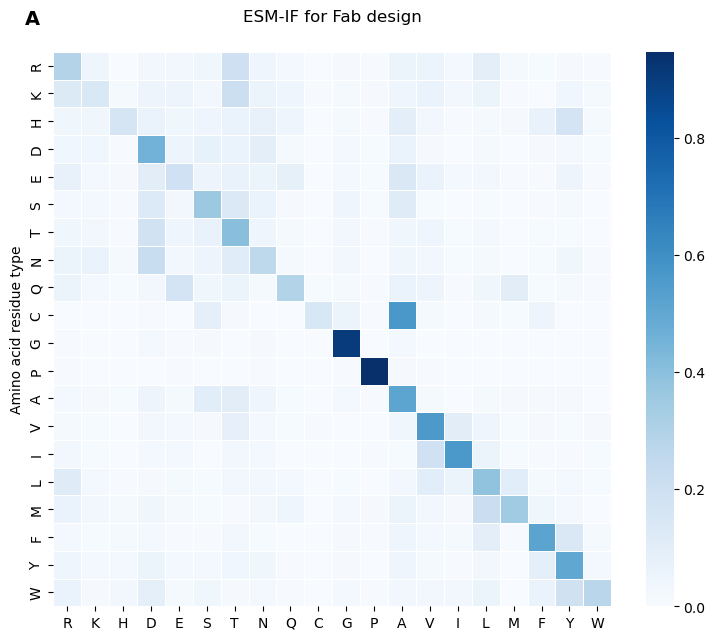

ploting for mpnn-fab-fullseq


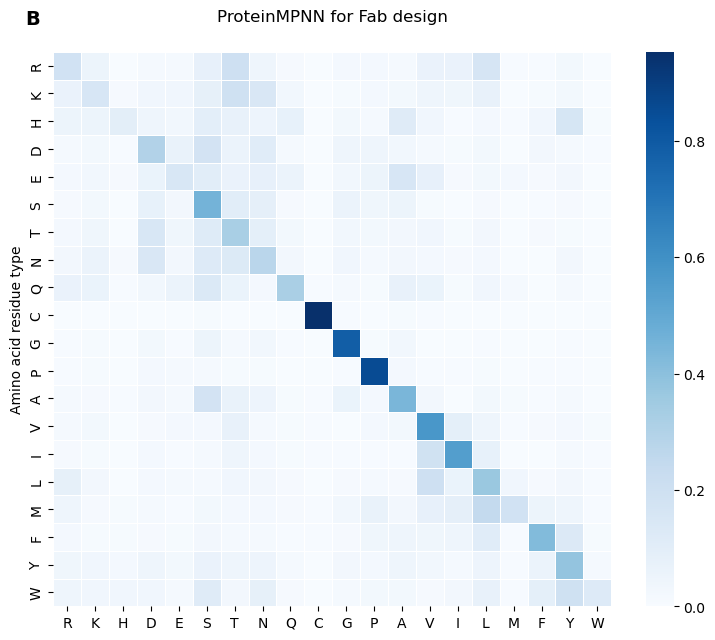

ploting for lm_design_vanilla-fab-fullseq


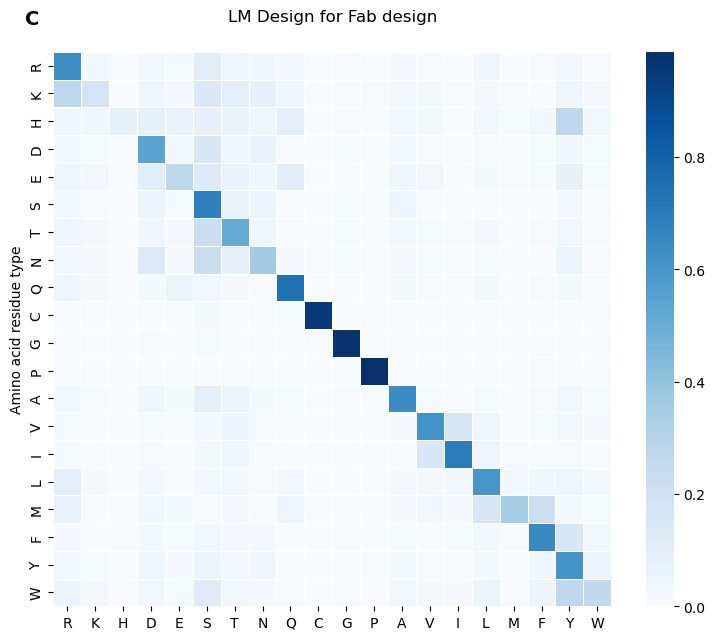

ploting for antifold-fab-fullseq


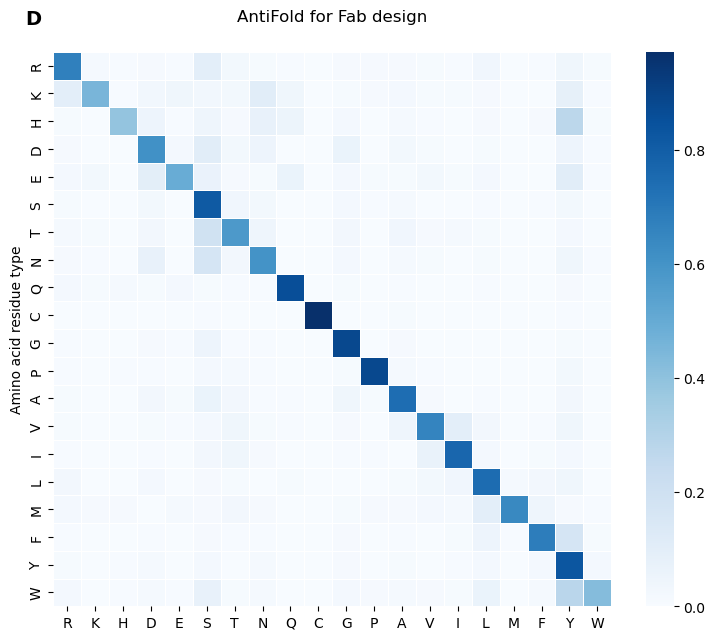

In [8]:
plot_heat_map(df_pos_all, Design_methods.design_methods_fab_1)

ploting for esm_if-vhh-fullseq


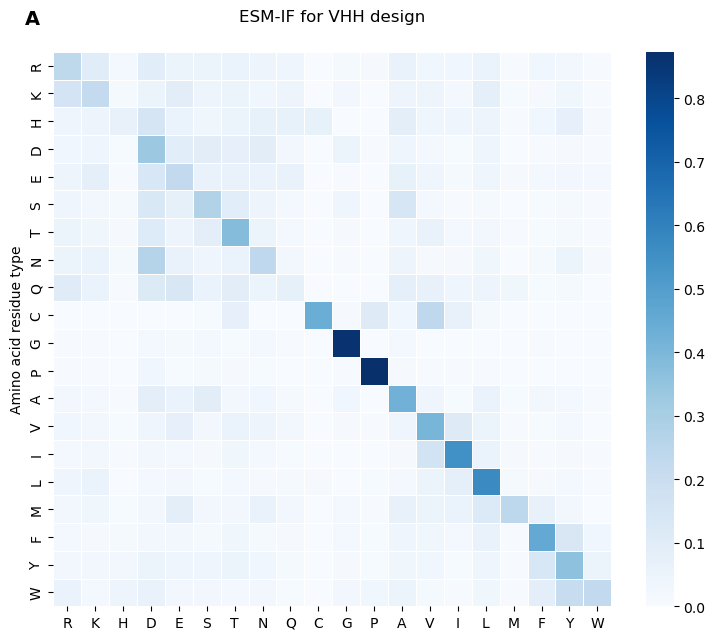

ploting for mpnn-vhh-fullseq


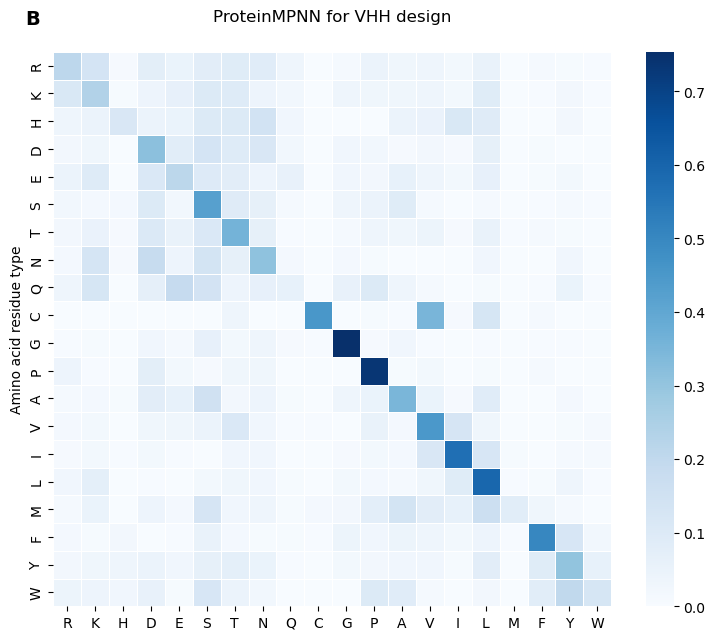

ploting for lm_design_vanilla-vhh-fullseq


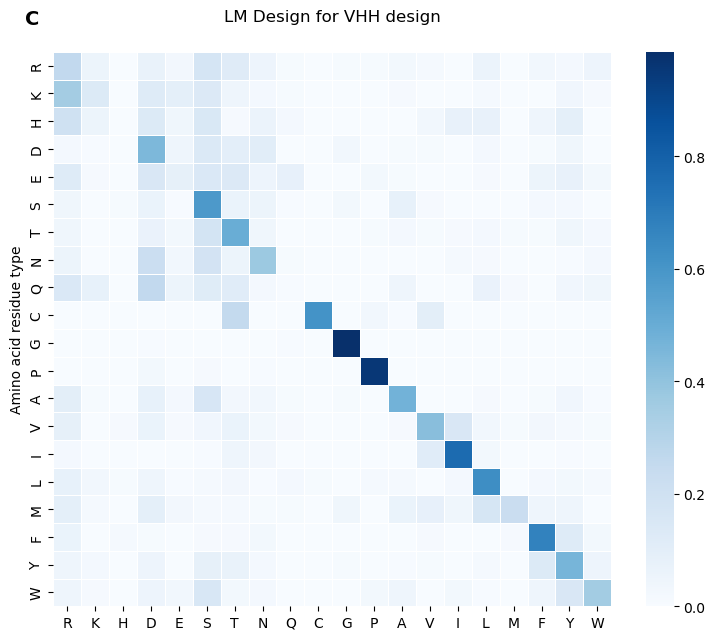

ploting for antifold-vhh-fullseq


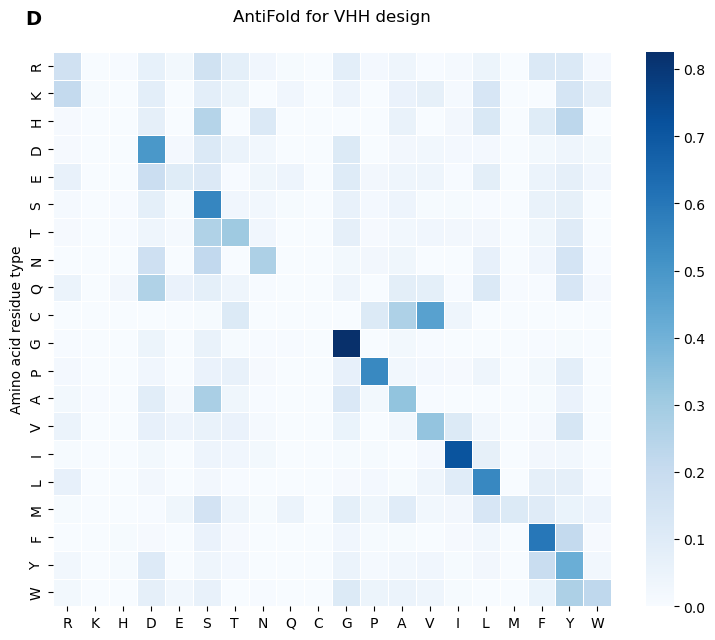

In [11]:
plot_heat_map(df_pos_all, Design_methods.design_methods_vhh_1)

## per aa type matrix

### full plot

In [12]:
def plotting_res_matrix(df_pos_all, design_methods, compare='method', label='A'):
    import logomaker

    fig, axes = plt.subplots(5, 4, figsize=(15*0.7, 25*0.7))
    axes_flat = axes.flatten()
    if compare=='method':
        labels = [exps.exp_info[k]['NAME'] for k in design_methods]
    else:
        labels = design_methods
    for i, aa in enumerate(aa_list):
        ax = axes_flat[i]

        dfs = []
        for k in design_methods:
            df_pos = df_pos_all[df_pos_all['task_id'] == k]

            df_pos_gp = get_df_pos_group(df_pos)

            df_pos_gp = df_pos_gp.iloc[:,:20] # this is to keep only carnonical residues, removing non-canonical residues, e.g. X, B 
            dfs.append(df_pos_gp[df_pos_gp.index == aa])


        alignment_df = pd.concat(dfs)
        alignment_df = alignment_df.reset_index(drop=True)

        logo = logomaker.Logo(alignment_df, 
                                ax = ax, 
                                color_scheme="weblogo_protein")

        ax.set_xticks(range(len(labels)))  # Set xticks based on design methods
        
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=14)  # Rotate xticks

        ax.set_title(f"{restype_1to3[aa]}")

    fig.text(0, 1, label, fontsize=24, fontweight='bold')
    plt.tight_layout()
    plt.show()


Matplotlib is building the font cache; this may take a moment.
/nfs_beijing/kubeflow-user/yifan/.local/lib/python3.10/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f32017a1690>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/nfs_beijing/kubeflow-user/yifan/.local/lib/python3.10/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f32017a29b0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/nfs_beijing/kubeflow-user/yifan/.local/lib/python3.10/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated

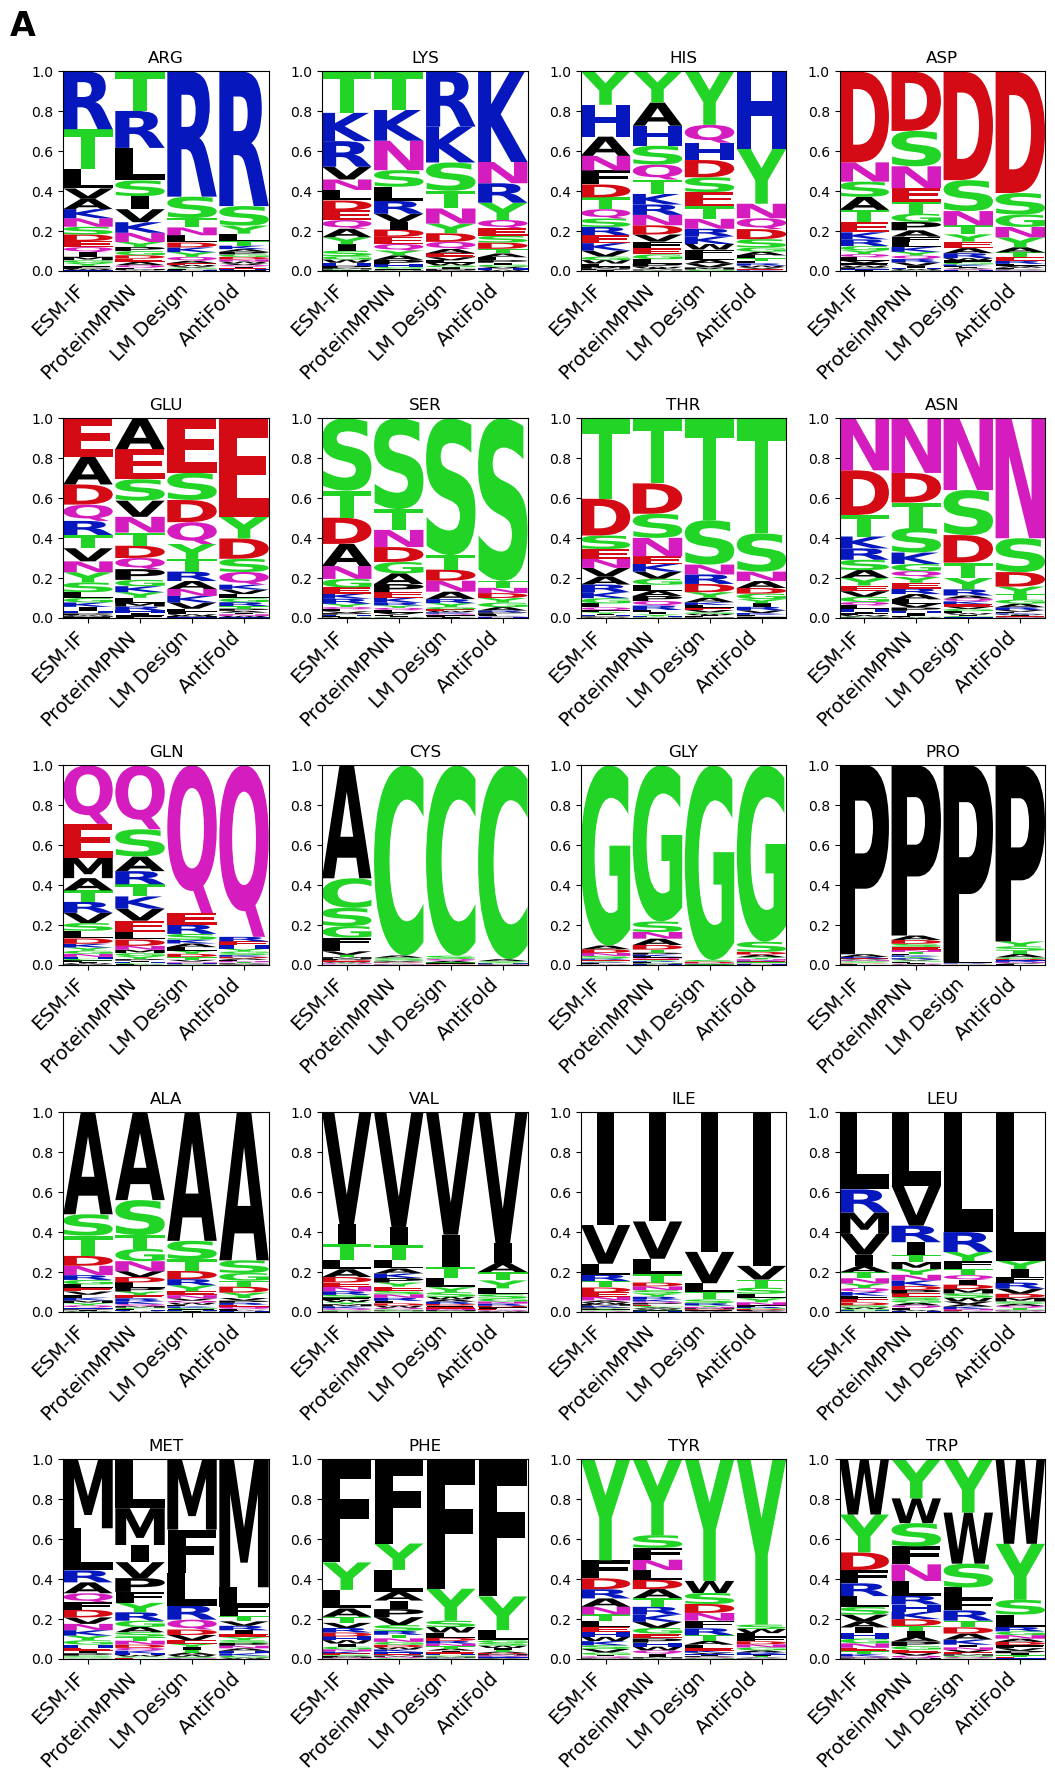

In [13]:
plotting_res_matrix(df_pos_all, Design_methods.design_methods_fab_1)

/nfs_beijing/kubeflow-user/yifan/.local/lib/python3.10/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f31ffdae740>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/nfs_beijing/kubeflow-user/yifan/.local/lib/python3.10/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f31ffdae9b0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/nfs_beijing/kubeflow-user/yifan/.local/lib/python3.10/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.

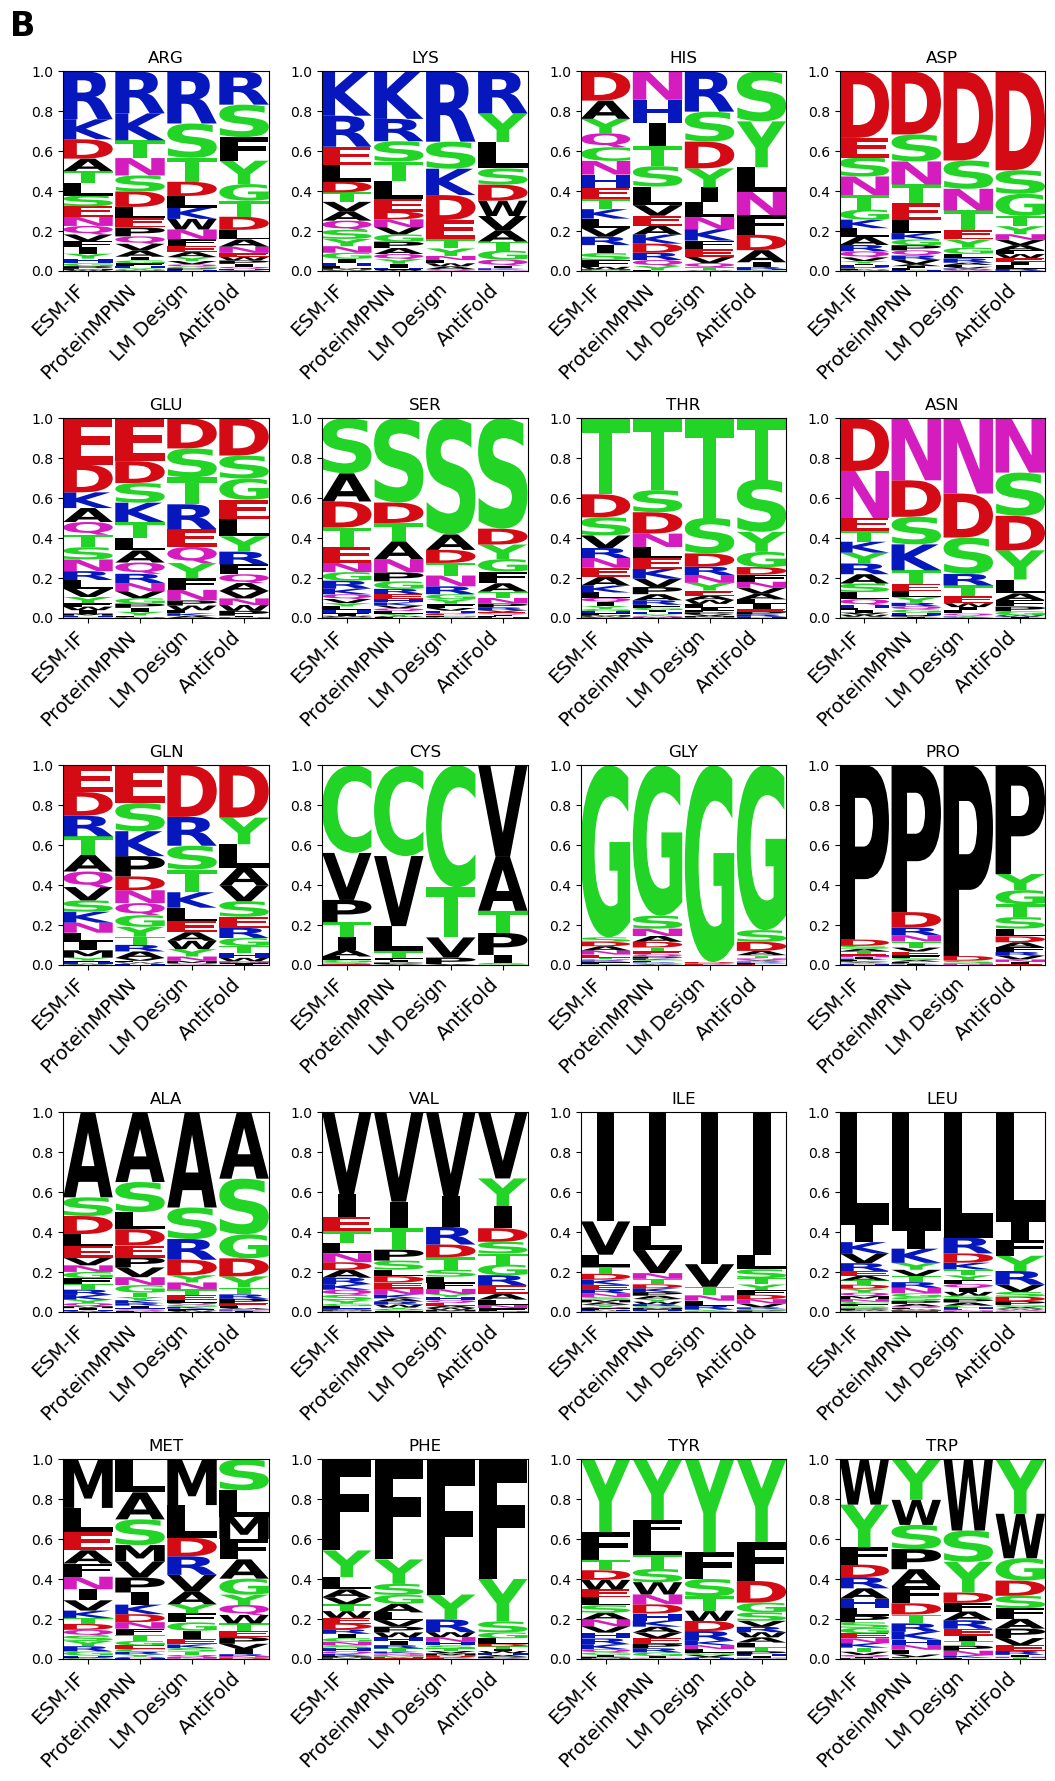

In [14]:
plotting_res_matrix(df_pos_all, Design_methods.design_methods_vhh_1, label="B")

### entropy

In [99]:
def plotting_res_matrix(df_pos_all, design_methods, antibody_type):
    import logomaker

    fig, axes = plt.subplots(4, 1, figsize=(10, 10))
    axes_flat = axes.flatten()



    _df = df_pos_all[df_pos_all['task_id'].isin(design_methods)]

    _df['Design Method'] = _df['task_id']

    for i, method in enumerate(design_methods):
        ax = axes_flat[i]

        dfs = []
        if 'task_id' in _df.columns:
            _df_task = _df[_df['task_id'] == method]
            _df_task = _df_task.drop(columns=['task_id'])
            
            
        df_task_group = _df_task.groupby('wt_aa').agg('sum').reset_index()
        
        if 'X' in df_task_group.columns:
            df_task_group = df_task_group.drop(columns=['X'])
        if '-' in df_task_group.columns:
            df_task_group = df_task_group.drop(columns=['-'])
        df_task_group['wt_aa'] = pd.Categorical(df_task_group['wt_aa'], categories=list(restype_1to3.keys()), ordered=True)
        df_task_group = df_task_group.sort_values('wt_aa')
        df_task_group.index = df_task_group['wt_aa']
        # print(df_pos_group.head())

        df_task_group = df_task_group.iloc[:, 4:-1]
        # print(df_pos_group.head())
        df_pos_gp = df_task_group.apply(lambda x: x / x.sum(), axis=1)
        # dfs = [exp_results[k].df_pos_gp.iloc[:, :20][exp_results[k].df_pos_gp.index == aa] for k in design_methods]


        entropies = df_pos_gp.apply(lambda p: -np.sum(p * np.log2(p+1e-12)), axis=1)  # 


        max_entropy = np.log2(20)
        info_content = max_entropy - entropies


        adjusted_freq_df = df_pos_gp.multiply(info_content, axis=0)

        alignment_df = adjusted_freq_df
        alignment_df = alignment_df.reset_index(drop=True)


        logo = logomaker.Logo(alignment_df, 
                                ax = ax, 
                                # vpad=.3,
                                width=0.9,
                                color_scheme="weblogo_protein")
        ax.set_ylim([0, 4.5])
        ax.set_ylabel('Adjusted Frequency')
        ax.set_xticks(range(len(restype_1to3.keys())))  # Set xticks based on design methods
        
        ax.set_xticklabels(restype_1to3.keys()
                            # , ha='right'
                            )
        ax.set_title(f"{exps.exp_info[method]['NAME']}")


    plt.tight_layout()
    plt.savefig(f"../results/Fig-3-{antibody_type}.png", dpi=300, bbox_inches='tight')  # bbox_inches='tight' 

    plt.show()


def plotting_res_matrix2(df_pos_all, design_methods, antibody_type):
    import logomaker

    fig, axes = plt.subplots(4, 1, figsize=(10, 10))
    axes_flat = axes.flatten()



    _df = df_pos_all[df_pos_all['task_id'].isin(design_methods)]

    _df['Design Method'] = _df['task_id']

    for i, method in enumerate(design_methods):
        ax = axes_flat[i]

        dfs = []
        if 'task_id' in _df.columns:
            _df_task = _df[_df['task_id'] == method]
            _df_task = _df_task.drop(columns=['task_id'])
            
            
        df_task_group = _df_task.groupby('wt_aa').agg('sum').reset_index()
        
        if 'X' in df_task_group.columns:
            df_task_group = df_task_group.drop(columns=['X'])
        if '-' in df_task_group.columns:
            df_task_group = df_task_group.drop(columns=['-'])
        df_task_group['wt_aa'] = pd.Categorical(df_task_group['wt_aa'], categories=list(restype_1to3.keys()), ordered=True)
        df_task_group = df_task_group.sort_values('wt_aa')
        df_task_group.index = df_task_group['wt_aa']
        # print(df_pos_group.head())

        df_task_group = df_task_group.iloc[:, 4:-1]
        # print(df_pos_group.head())
        df_pos_gp = df_task_group.apply(lambda x: x / x.sum(), axis=1)
        # dfs = [exp_results[k].df_pos_gp.iloc[:, :20][exp_results[k].df_pos_gp.index == aa] for k in design_methods]


        entropies = df_pos_gp.apply(lambda p: -np.sum(p * np.log2(p+1e-12)), axis=1)  


        max_entropy = np.log2(20)
        info_content = max_entropy - entropies

        adjusted_freq_df = df_pos_gp.multiply(info_content, axis=0)


        alignment_df = adjusted_freq_df
        alignment_df = alignment_df.reset_index(drop=True)


        logo = logomaker.Logo(alignment_df, 
                                ax = ax, 
                                # vpad=.3,
                                width=0.9,
                                color_scheme="weblogo_protein")
        ax.set_ylim([0, 4.5])
        ax.set_ylabel('Adjusted Frequency')
        ax.set_xticks(range(len(restype_1to3.keys())))  # Set xticks based on design methods
        
        ax.set_xticklabels(restype_1to3.keys()
                            # , ha='right'
                            )
        ax.set_title(f"{exps.exp_info[method]['NAME']}")


    plt.tight_layout()
    plt.savefig(f"../results/Fig-3-{antibody_type}.png", dpi=300, bbox_inches='tight')  # bbox_inches='tight'

    plt.show()


/tmp/ipykernel_45259/3142378932.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['Design Method'] = _df['task_id']


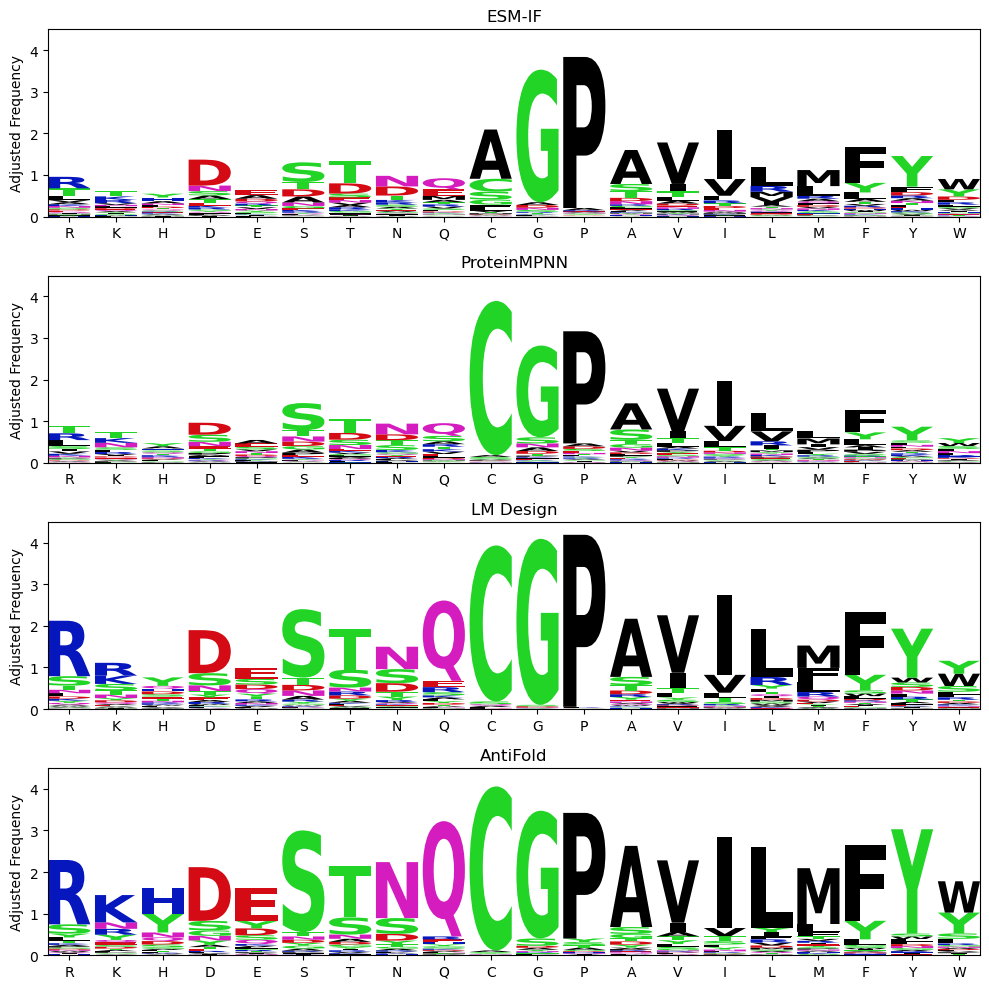

In [100]:
plotting_res_matrix2(df_pos_all, Design_methods.design_methods_fab_1, 'fab')


/tmp/ipykernel_45259/3142378932.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['Design Method'] = _df['task_id']


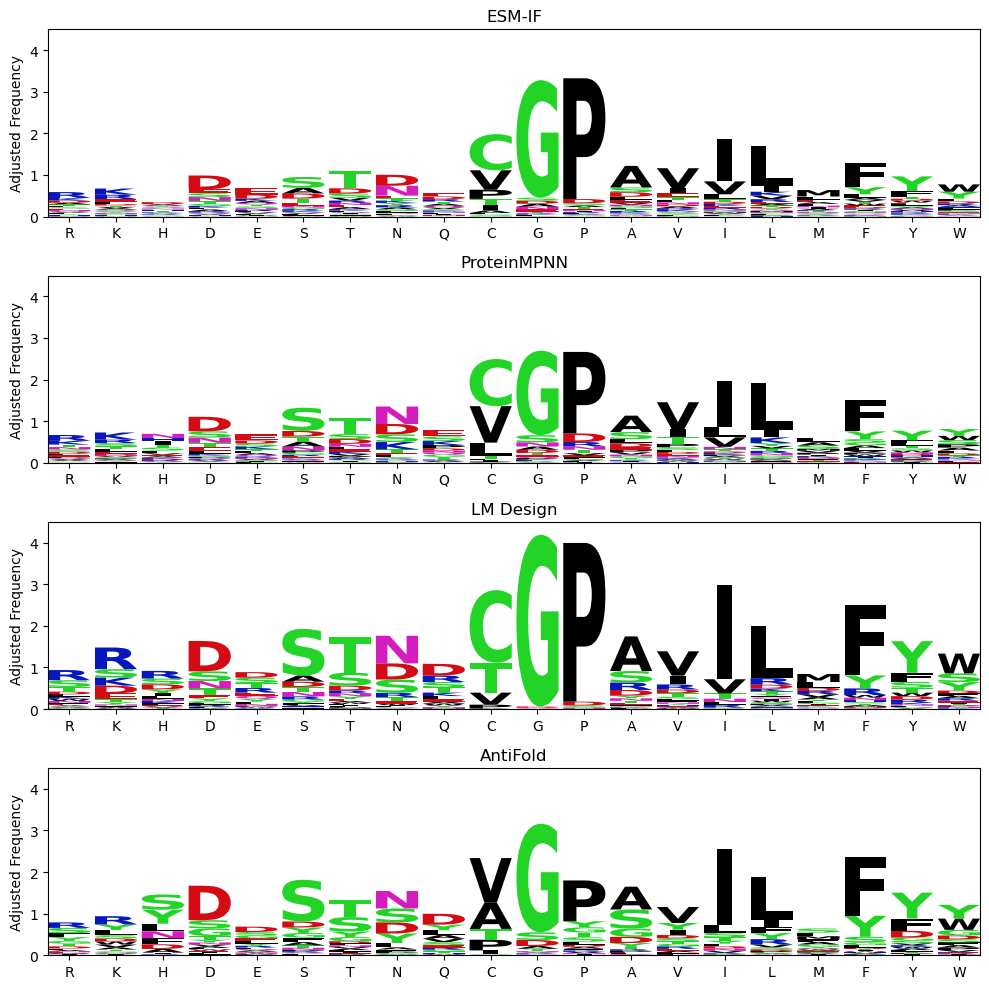

In [101]:
plotting_res_matrix2(df_pos_all, Design_methods.design_methods_vhh_1, 'vhh')

## CDR region recovery corelation

In [20]:
def cdr_recovery_corelation(df_pos_all, methods, antibody_type):
    if antibody_type == 'fab':
        cols = Metrics.full_recovery
    elif antibody_type == 'vhh':
        cols = Metrics.vhh_recovery
    else:
        raise ValueError("not supporting this antibody_type")

    for i, k in enumerate(methods):
        print(f"ploting for {k}")
        df_pdb = df_pdb_all[df_pdb_all['task_id'] == k]

        df_pdb = df_pdb[cols]

        
        df_pdb = df_pdb.rename(columns = {k: f"{k[-6]}{k[-1]}" for k in Metrics.full_recovery})
        ax = sns.pairplot(df_pdb, plot_kws={'s': 10})

        ax.fig.suptitle(f"{exps.exp_info[k]['NAME']}", y=1.04)

        plt.text(0.0, 1.04, "ABCD"[i], transform=ax.fig.transFigure, fontsize=14, fontweight='bold')
        ax.fig.subplots_adjust(hspace=0.15, wspace=0.15)
        ax.fig.set_size_inches(7, 7)
        plt.show()




ploting for esm_if-fab-fullseq


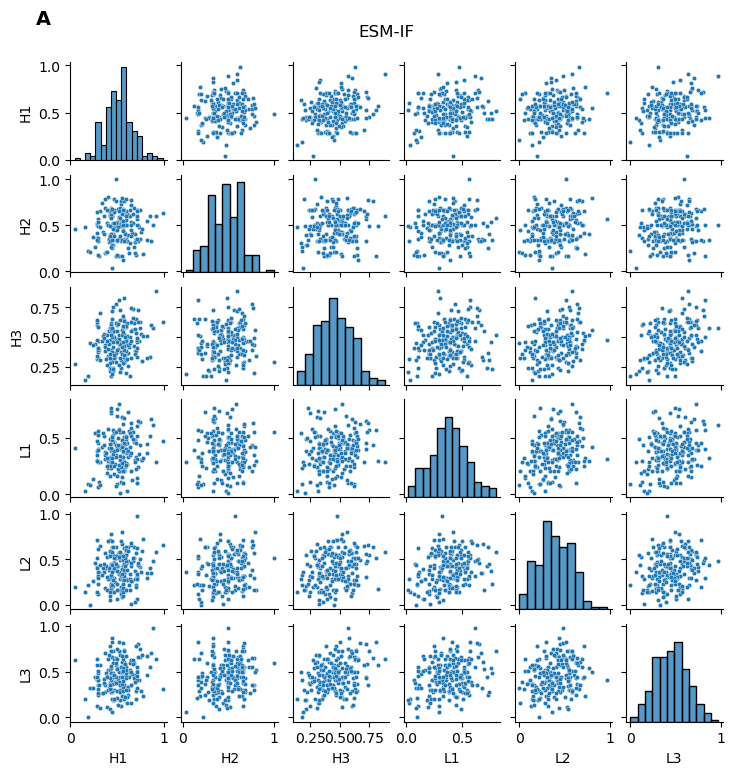

ploting for mpnn-fab-fullseq


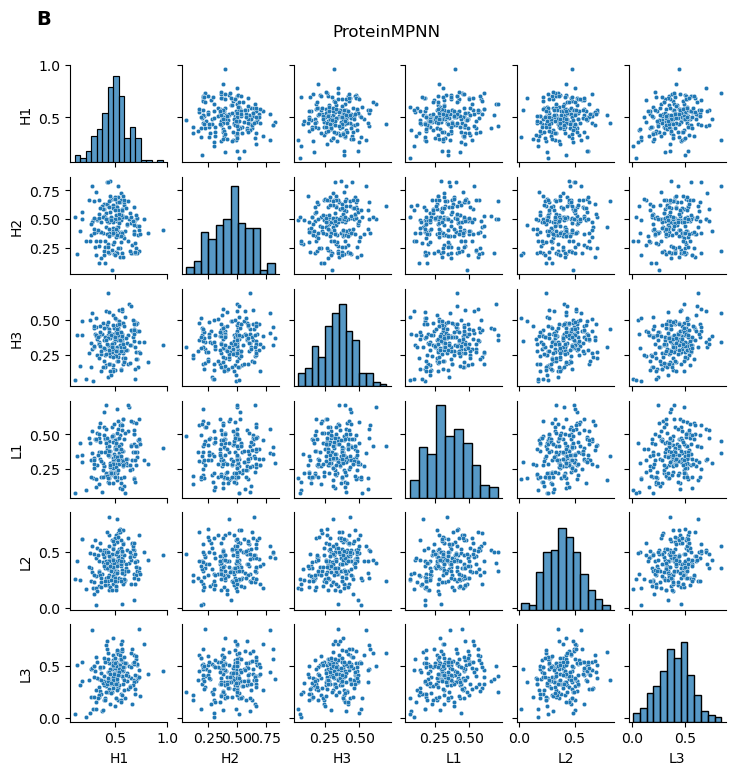

ploting for lm_design_vanilla-fab-fullseq


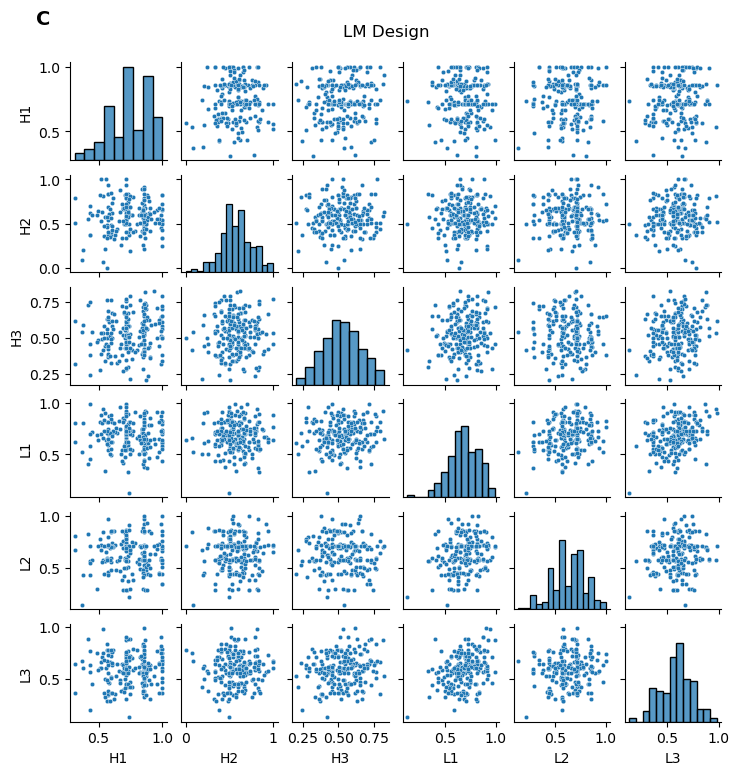

ploting for antifold-fab-fullseq


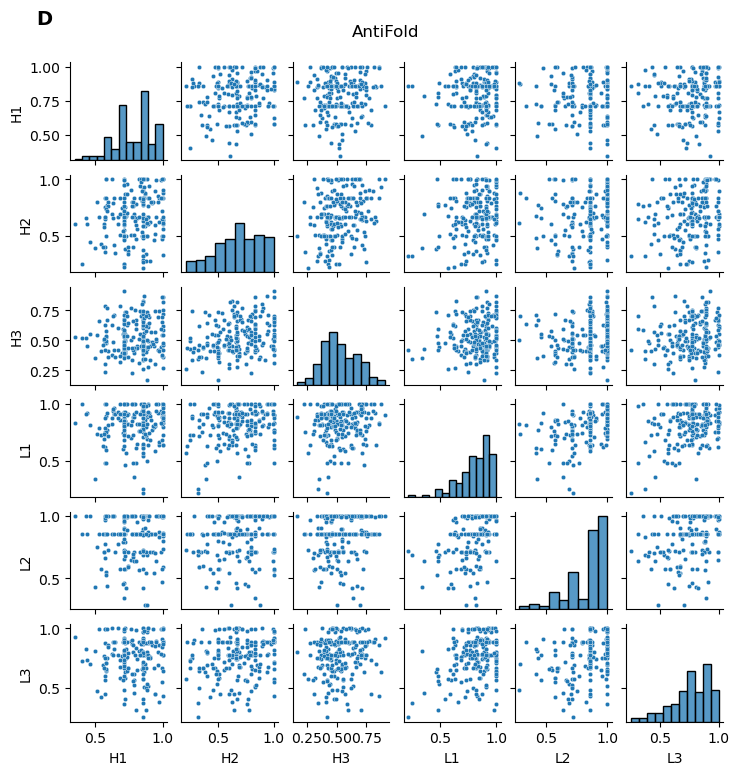

In [21]:
cdr_recovery_corelation(df_pdb_all, Design_methods.design_methods_fab_1, antibody_type='fab')

## Recovery for different methods

#### fab

In [22]:
def plot_for_recovery(df_pdb_all, methods, antibody_type, metrics = None):
    if antibody_type == 'fab':
        metrics = Metrics.full
        fig, axes = plt.subplots(5, 3, figsize=(12, 20))
    elif antibody_type == 'vhh':
        metrics = Metrics.vhh
        fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    else:
        raise ValueError("not supporting this antibody_type")

    _df_pdb_all = df_pdb_all[df_pdb_all['task_id'].isin(methods)]
    _df_pdb_all['model'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]

    
    axes_flat = axes.flatten()


    for i, metric in enumerate(metrics):
        df = _df_pdb_all[[metric, 'model']]
        ax = axes_flat[i]
        palette = sns.color_palette("muted", n_colors=df['model'].nunique())  
        sns.boxplot(data=df, x='model', y=metric, ax=ax, palette=palette)
        ax.set_title(metric_map2[metric])

        if "identity" in metric:
            ax.set_ylabel("Recovery Rate")
        elif "similarity_B62" in metric:
            ax.set_ylabel("BLOSM62 Similarity")
        
        ax.set_xlabel("")


        ticks = ax.get_xticks()

        ax.set_xticks(ticks)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
    num_metrics = len(metrics)
    for j in range(num_metrics, len(axes_flat)):
        fig.delaxes(axes_flat[j])
    plt.tight_layout()
    plt.show()


def plot_for_recovery2(df_pdb_all, methods, antibody_type, title, metrics = None):

    metric_map = {
        'identity-H_CDR3': 'Recovery for H3',
        'similarity_B62-H_CDR3': 'BLOSM62 similarity for H3',
        'identity-cdr_concat': 'Recovery for concatinated CDRs',
        'similarity_B62-cdr_concat': 'BLOSM62 similarity for concatinated CDRs',
        'similarity_B62-H_CDR1': 'BLOSM62 similarity for H1', 
        'similarity_B62-H_CDR2': 'BLOSM62 similarity for H2'
    }
    metric_map2 = {
        'identity-H_CDR3': 'Recovery for H3',
        'similarity_B62-H_CDR3': 'H3',
        'identity-cdr_concat': 'Recovery for concatinated CDRs',
        'similarity_B62-cdr_concat': 'BLOSM62 similarity for concatinated CDRs',
        'similarity_B62-H_CDR1': 'H1', 
        'similarity_B62-H_CDR2': 'H2',
        'similarity_B62-cdr_concat': 'concatenated CDRs'
    }

    _df_pdb_all = df_pdb_all[df_pdb_all['task_id'].isin(methods)]
    _df_pdb_all['Design Method'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]

    fig, axes = plt.subplots(1, 1, figsize=(15*0.6, 5*0.6))
    dfs = []
    for i, metric in enumerate(metrics):

        df = _df_pdb_all[[metric, 'Design Method']]
        df['BLOSM62 Similarity'] = df[metric]
        df['metric'] = metric_map2[metric]
        dfs.append(df)

    _df_all = pd.concat(dfs)


    palette = sns.color_palette("muted", n_colors=_df_all['Design Method'].nunique()) 
    g = sns.boxplot(
        data=_df_all,
        hue='Design Method',
        y='BLOSM62 Similarity',
        x='metric', 
        palette=palette
    )
    g.set(xlabel=None)
    # g.set_title(xlabel=None)
    g.legend(loc='center left', bbox_to_anchor=(1, 0), title='')
    g.set_title(title)
    # g.tight_layout()
    plt.savefig(f"../results/Fig-1-{antibody_type}.png", dpi=300, bbox_inches='tight')  # bbox_inches='tight' 

    plt.show()


### fab simple

/tmp/ipykernel_45259/2445883075.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pdb_all['Design Method'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]
/tmp/ipykernel_45259/2445883075.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BLOSM62 Similarity'] = df[metric]
/tmp/ipykernel_45259/2445883075.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

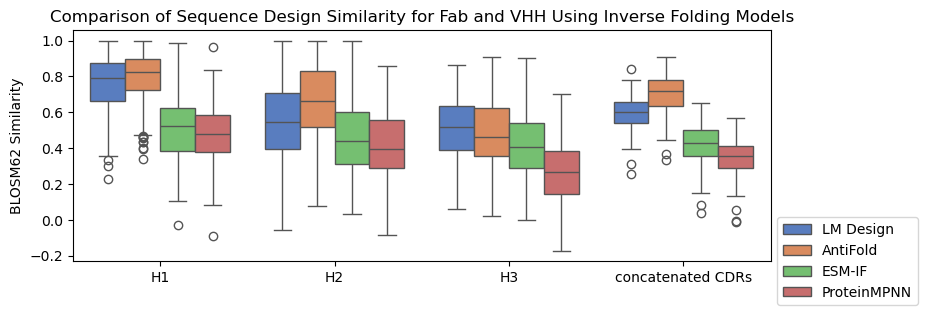

In [23]:
plot_for_recovery2(df_pdb_all, methods=Design_methods.design_methods_fab_1, antibody_type='fab', title = "Comparison of Sequence Design Similarity for Fab and VHH Using Inverse Folding Models", metrics = Metrics.vhh_similarity)

/tmp/ipykernel_45259/2445883075.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pdb_all['Design Method'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]
/tmp/ipykernel_45259/2445883075.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BLOSM62 Similarity'] = df[metric]
/tmp/ipykernel_45259/2445883075.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

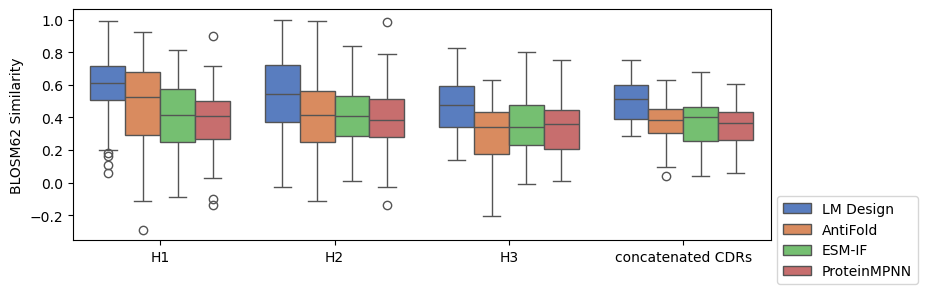

In [26]:
plot_for_recovery2(df_pdb_all, methods=Design_methods.design_methods_vhh_1, antibody_type='vhh', title = "", metrics = Metrics.vhh_similarity)

### full plot

/tmp/ipykernel_45259/2445883075.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pdb_all['model'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]
/tmp/ipykernel_45259/2445883075.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='model', y=metric, ax=ax, palette=palette)
/tmp/ipykernel_45259/2445883075.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='model', y=metric, ax=ax, palette=palette)
/tmp/ipyk

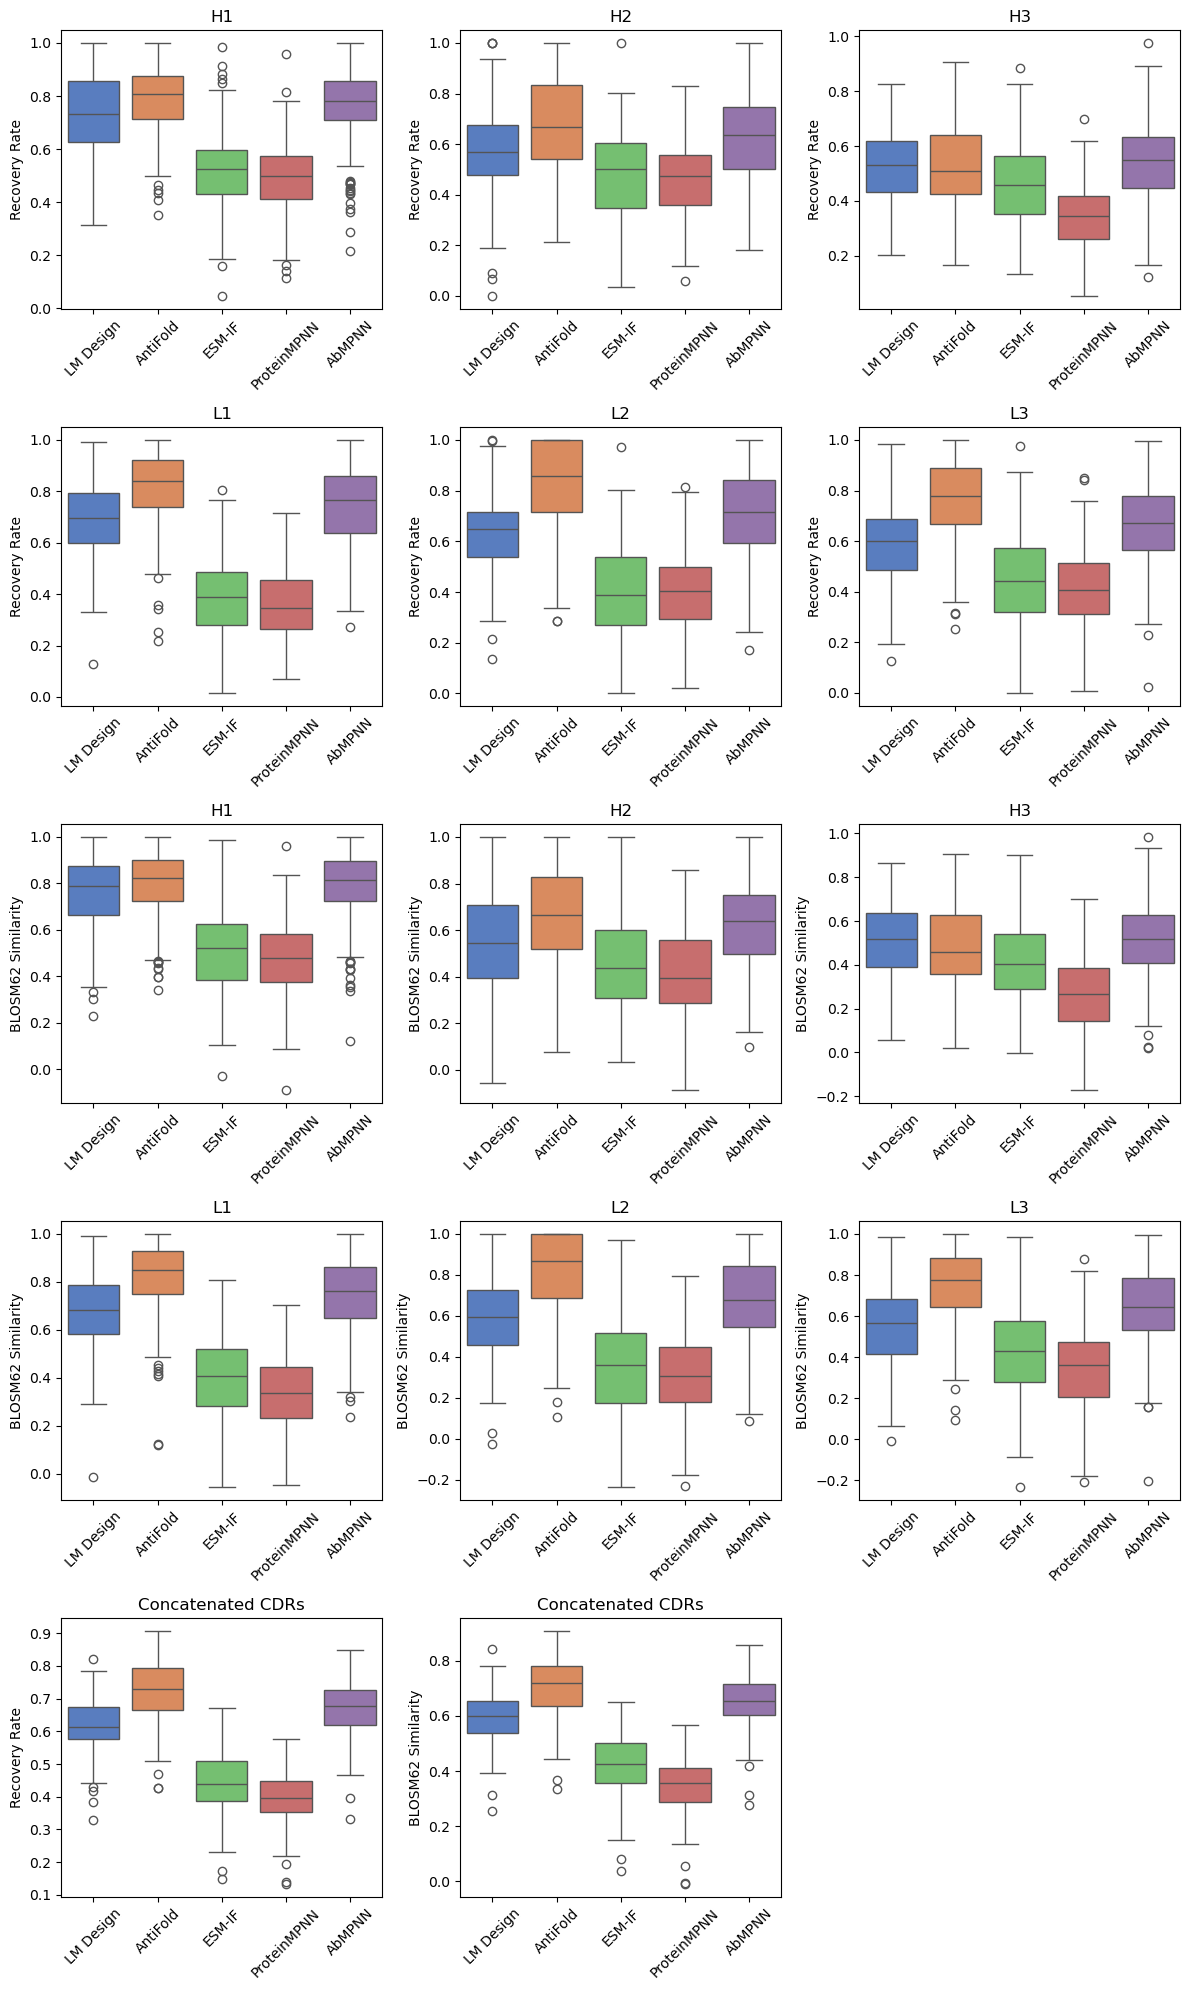

In [27]:
plot_for_recovery(df_pdb_all, methods=Design_methods.design_methods_fab, antibody_type='fab')

/tmp/ipykernel_45259/2445883075.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pdb_all['model'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]
/tmp/ipykernel_45259/2445883075.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='model', y=metric, ax=ax, palette=palette)
/tmp/ipykernel_45259/2445883075.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='model', y=metric, ax=ax, palette=palette)
/tmp/ipyk

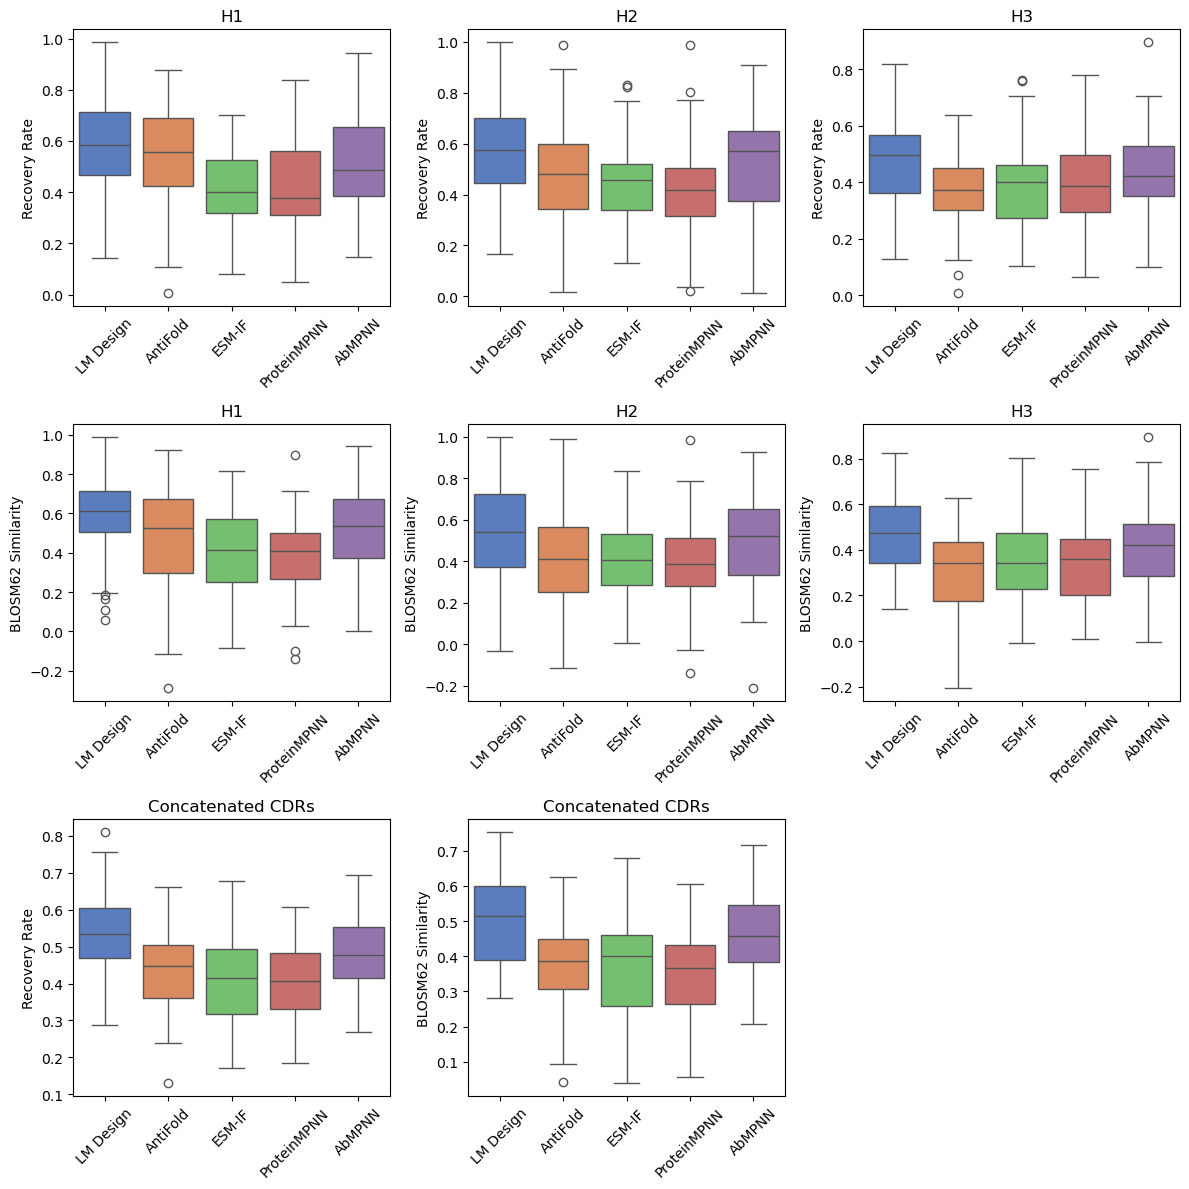

In [28]:
plot_for_recovery(df_pdb_all, methods=Design_methods.design_methods_vhh, antibody_type='vhh')

### with vs without antigen structure

In [32]:
def merge_df_pdb(df_pdb_all, metric, design_methods, using_method_name=True):

    df_merge = pd.DataFrame()
    for k in design_methods:
        df_pdb = df_pdb_all[df_pdb_all['task_id'] == k][['pdb_name', metric]]
        if using_method_name:
            df_pdb = df_pdb.rename(columns = {metric: exps.exp_info[k]['NAME']})
        else:
            df_pdb = df_pdb.rename(columns = {metric: k})
            
        if len(df_merge) == 0:
            df_merge = df_pdb
        else:
            df_merge = pd.merge(df_merge, df_pdb, on='pdb_name')

    return df_merge

def pair_plot_different_methods(df_pos_all, methods, antibody_type, using_method_name=True, fig_lab="AB", model="ESM-IF"):
    _df_pdb_all = df_pdb_all[df_pdb_all['task_id'].isin(methods)]
    _df_pdb_all['model'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]
    # print(_df_pdb_all.head())


    metrics = ['similarity_B62-cdr_concat', 'similarity_B62-H_CDR3']
    metrics_labels = ['Concatenated CDRs', 'H3']
    for i, metric in enumerate(metrics):

        df_merge = merge_df_pdb(_df_pdb_all, metric, design_methods=methods, using_method_name = using_method_name)
        print(f'Ploting for {metric}')
        df_merge = df_merge.drop(columns=["pdb_name"])
        df_merge.columns = ['Ag-' if 'noAG' in col else 'Ag+' for col in df_merge.columns]

        # fig, axes = plt.subplots(5, 3, figsize=(12, 20))
        plt.figure(figsize=(4, 4))
        g = sns.scatterplot(data=df_merge, x="Ag-", y="Ag+")


        g.set_xlim(0, 1)  
        g.set_ylim(0, 1)  
        g.plot([0, 1], [0, 1], 'k--')

        corr_value = df_merge["Ag-"].corr(df_merge["Ag+"])  # calculate corr

        # add into the text
        g.text(0.05, 0.9, f"Corr = {corr_value:.2f}", fontsize=10, transform=g.transAxes)

        

        print(f"Comparison of {metric_map[metric]} for {antibody_type_map[antibody_type]} design")

        g.figure.suptitle(f"{metrics_labels[i]} design with {model}", y=0.95, fontsize=10)
        plt.text(-0.02, 0.94, fig_lab[i], transform=g.figure.transFigure, fontsize=14, fontweight='bold')
        # g.figure.subplots_adjust(hspace=0.15, wspace=0.15)
        # g.figure.set_size_inches(7, 7)
    
    plt.show()

/tmp/ipykernel_45259/1309706950.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pdb_all['model'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]


Ploting for similarity_B62-cdr_concat
Comparison of BLOSM62 similarity for concatenated CDRs for Fab design
Ploting for similarity_B62-H_CDR3
Comparison of BLOSM62 similarity for H3 for Fab design


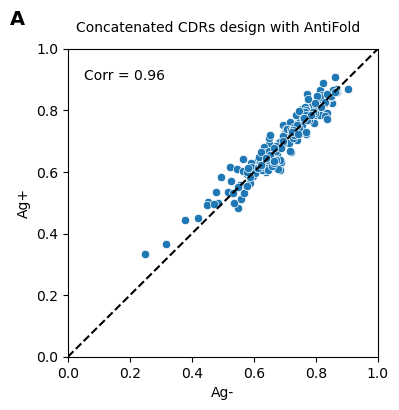

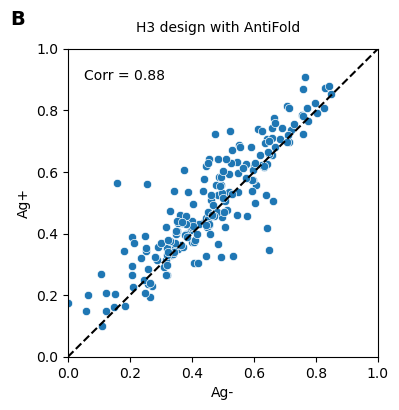

In [33]:
pair_plot_different_methods(df_pos_all, Design_methods.antifold_ag_noag, using_method_name=False, antibody_type='fab', fig_lab="AB", model="AntiFold")

Ploting for similarity_B62-cdr_concat
Comparison of BLOSM62 similarity for concatenated CDRs for Fab design
Ploting for similarity_B62-H_CDR3
Comparison of BLOSM62 similarity for H3 for Fab design


/tmp/ipykernel_45259/1309706950.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pdb_all['model'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]


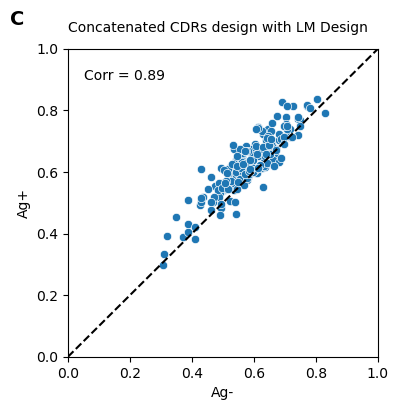

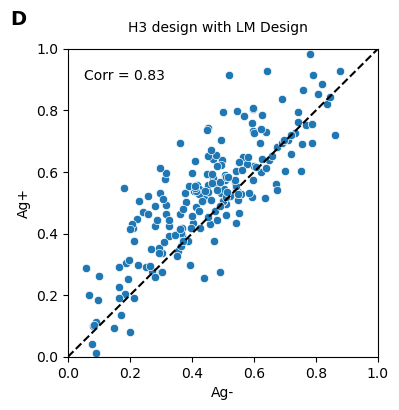

In [34]:
pair_plot_different_methods(df_pos_all, Design_methods.lm_design_ag_noag, using_method_name=False, antibody_type='fab', fig_lab="CD", model="LM Design")

Ploting for similarity_B62-cdr_concat
Comparison of BLOSM62 similarity for concatenated CDRs for Fab design
Ploting for similarity_B62-H_CDR3
Comparison of BLOSM62 similarity for H3 for Fab design


/tmp/ipykernel_45259/1309706950.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pdb_all['model'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]


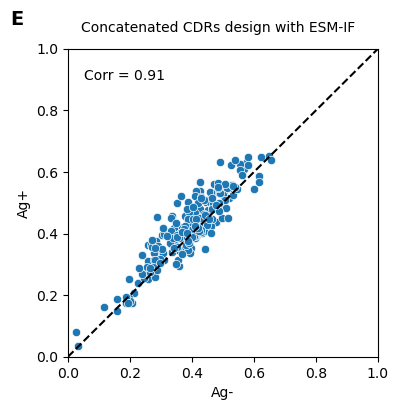

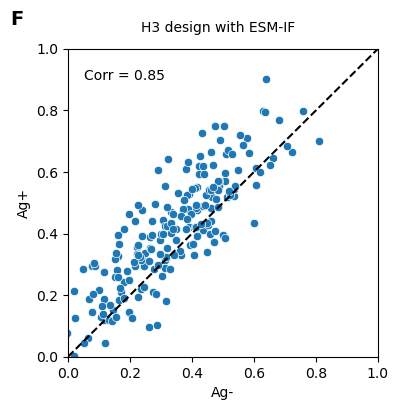

In [35]:
pair_plot_different_methods(df_pos_all, Design_methods.esm_if_ag_noag, using_method_name=False, antibody_type='fab', fig_lab="EF", model="ESM-IF")

## Recovery pairplot

### fab

In [36]:
def pair_plot_different_methods_corr(df_pos_all, methods, antibody_type, using_method_name=True):
    from scipy.stats import pearsonr
    _df_pdb_all = df_pdb_all[df_pdb_all['task_id'].isin(methods)]
    _df_pdb_all['model'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]
    # print(_df_pdb_all.head())




    for i, metric in enumerate(['identity-cdr_concat']):
        
        # merge data
        df_merge = merge_df_pdb(_df_pdb_all, metric, design_methods=methods, using_method_name = using_method_name)
        print(f'Plotting for {metric}')
        
        # create pairplot
        g = sns.pairplot(data=df_merge, corner=True, diag_kind=None, plot_kws={'s': 10})  
        

        for ax in g.axes.flatten():
            if ax is not None:  
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.plot([0, 1], [0, 1], 'k--')  # adding diagonal
                

                if ax.get_xlabel() != ax.get_ylabel():  
                    x = df_merge[ax.get_xlabel()]
                    y = df_merge[ax.get_ylabel()]
                    corr, _ = pearsonr(x, y)
                    

                    ax.text(0.23, 0.95, f"r = {corr:.2f}", ha='center', va='center', transform=ax.transAxes, fontsize=10, fontweight='bold')


        g.fig.suptitle(f"Comparison for different models for {metric} for {antibody_type} design", y=1.05)
        g.fig.subplots_adjust(hspace=0.15, wspace=0.15)
        g.fig.set_size_inches(8, 8)
        plt.savefig(f"../results/Fig-2-{antibody_type}.png", dpi=300, bbox_inches='tight')  # bbox_inches='tight'

        
        plt.show()



/tmp/ipykernel_45259/2334307331.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pdb_all['model'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]


Plotting for identity-cdr_concat


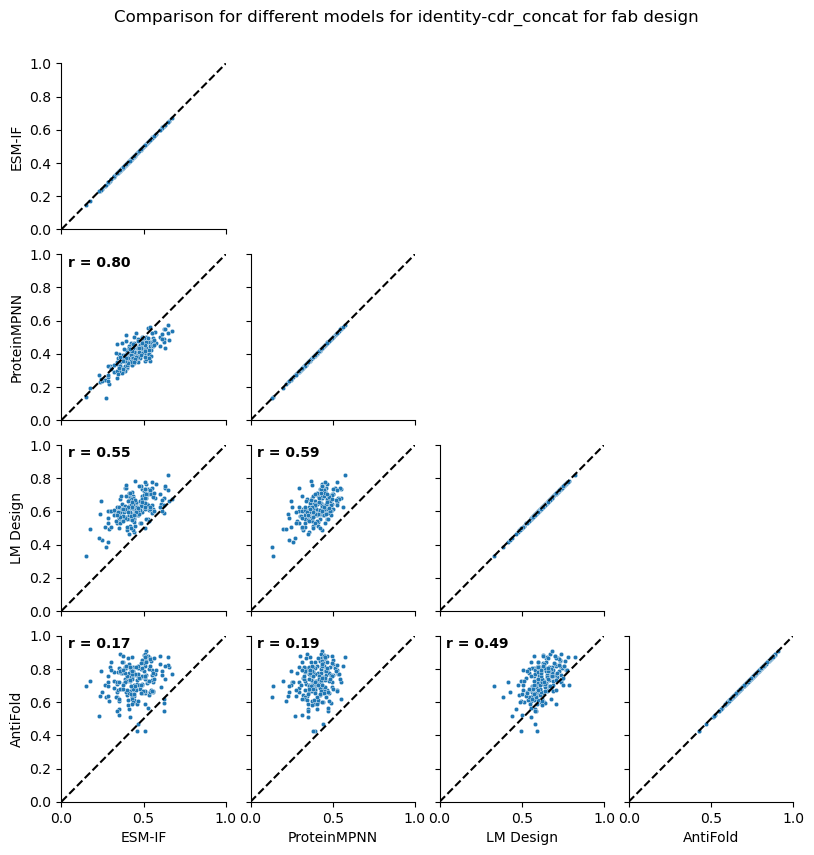

In [37]:
pair_plot_different_methods_corr(df_pos_all, Design_methods.design_methods_fab_1, antibody_type='fab')

### full plot

In [38]:
def merge_df_pdb(df_pdb_all, metric, design_methods, using_method_name=True):

    df_merge = pd.DataFrame()
    for k in design_methods:
        df_pdb = df_pdb_all[df_pdb_all['task_id'] == k][['pdb_name', metric]]
        if using_method_name:
            df_pdb = df_pdb.rename(columns = {metric: exps.exp_info[k]['NAME']})
        else:
            df_pdb = df_pdb.rename(columns = {metric: k})
            
        if len(df_merge) == 0:
            df_merge = df_pdb
        else:
            df_merge = pd.merge(df_merge, df_pdb, on='pdb_name')

    return df_merge



def pair_plot_different_methods(df_pos_all, methods, antibody_type, using_method_name=True):
    _df_pdb_all = df_pdb_all[df_pdb_all['task_id'].isin(methods)]
    _df_pdb_all['model'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]
    # print(_df_pdb_all.head())


    for i, metric in enumerate(Metrics.full_simple):
        
        df_merge = merge_df_pdb(_df_pdb_all, metric, design_methods=methods, using_method_name = using_method_name)
        print(f'Ploting for {metric}')

        # fig, axes = plt.subplots(5, 3, figsize=(12, 20))
        g = sns.pairplot(data=df_merge)


        for ax in g.axes.flatten():
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.plot([0, 1], [0, 1], 'k--')
        

        print(f"Comparison of {metric_map3[metric]} for {antibody_type_map[antibody_type]} design")

        g.fig.suptitle(f"Comparison of {metric_map3[metric]} for {antibody_type_map[antibody_type]} design", y=1.04)
        plt.text(0.0, 1.04, "ABCD"[i], transform=g.fig.transFigure, fontsize=14, fontweight='bold')
        g.fig.subplots_adjust(hspace=0.15, wspace=0.15)
        g.fig.set_size_inches(7, 7)
        plt.show()



/tmp/ipykernel_45259/970398566.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pdb_all['model'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]


Ploting for identity-H_CDR3
Comparison of Recovery Rate for H3 for Fab design


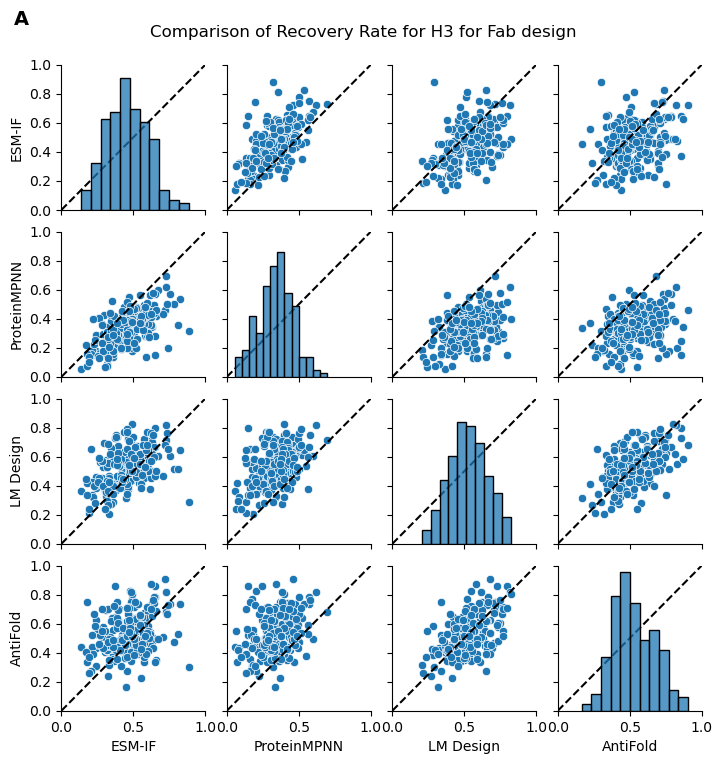

Ploting for similarity_B62-H_CDR3
Comparison of BLOSM62 Similarity for H3 for Fab design


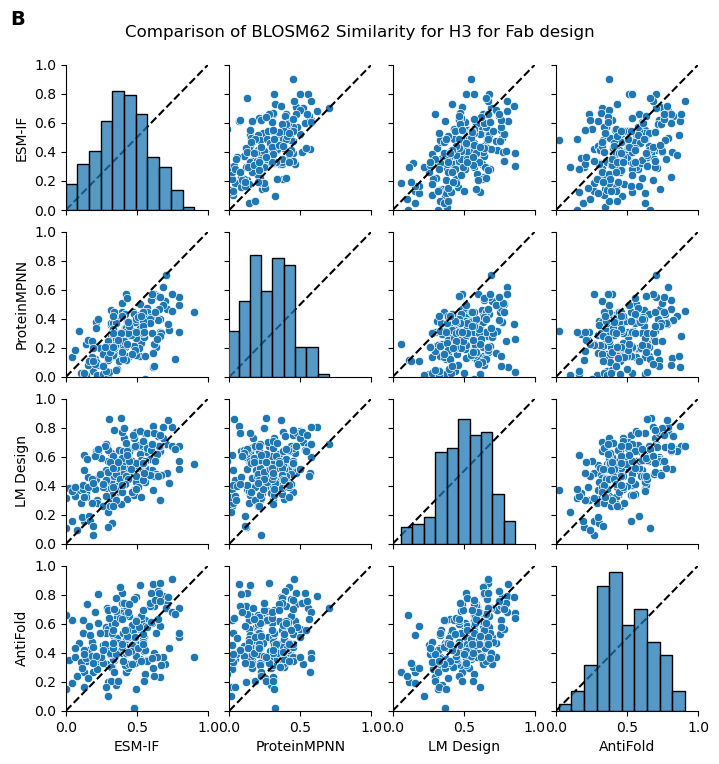

Ploting for identity-cdr_concat
Comparison of Recovery Rate for concatenated CDRs for Fab design


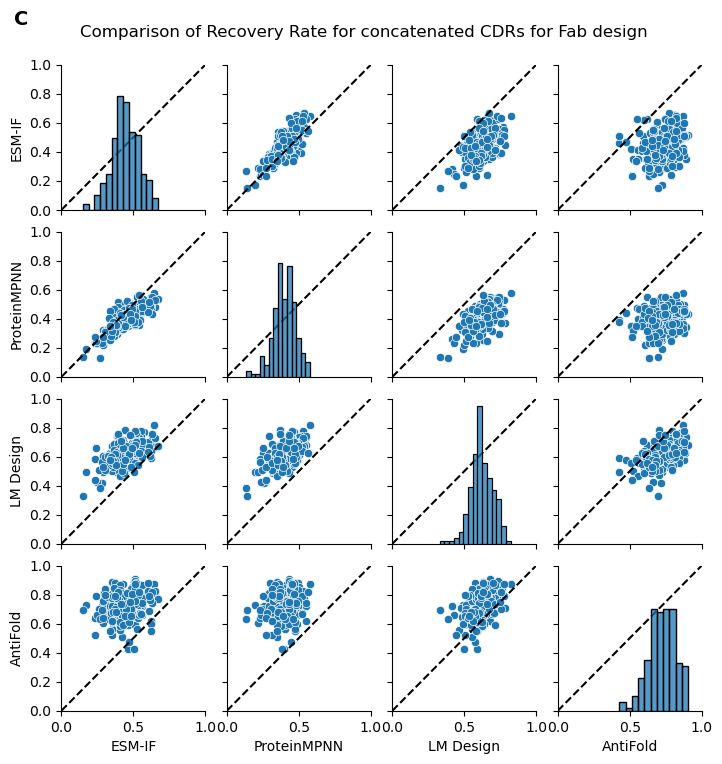

Ploting for similarity_B62-cdr_concat
Comparison of BLOSM62 Similarity for concatenated CDRs for Fab design


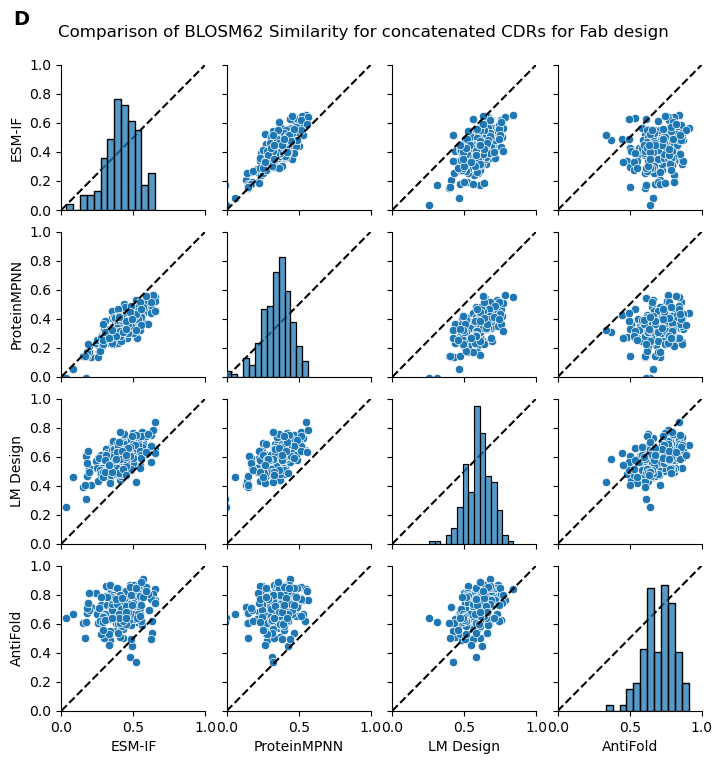

In [39]:
pair_plot_different_methods(df_pos_all, Design_methods.design_methods_fab_1, antibody_type='fab')

/tmp/ipykernel_45259/970398566.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pdb_all['model'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]


Ploting for identity-H_CDR3
Comparison of Recovery Rate for H3 for VHH design


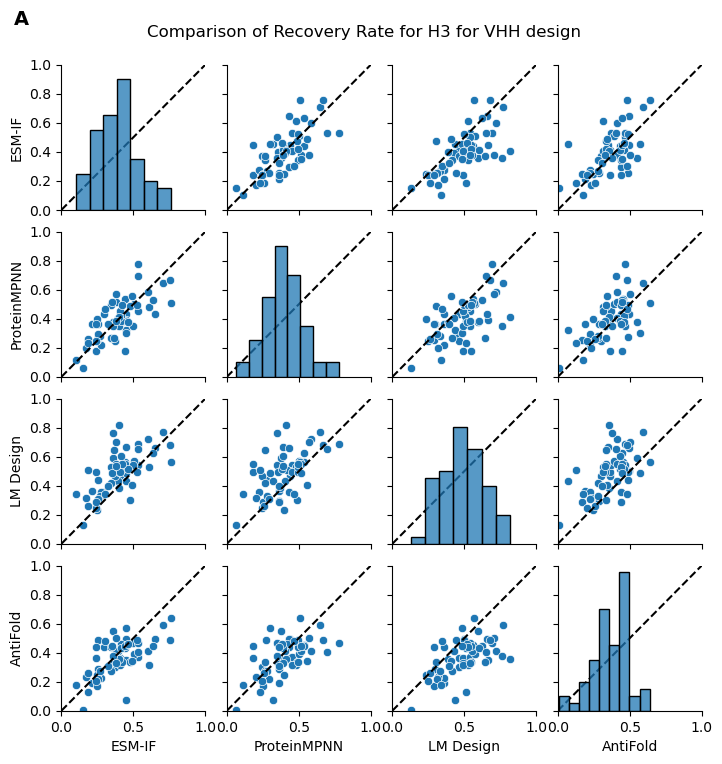

Ploting for similarity_B62-H_CDR3
Comparison of BLOSM62 Similarity for H3 for VHH design


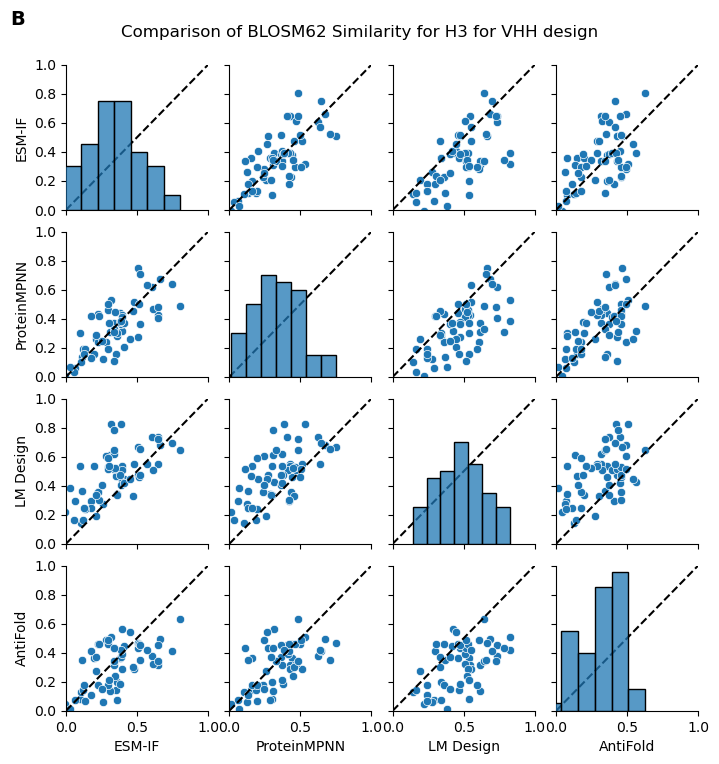

Ploting for identity-cdr_concat
Comparison of Recovery Rate for concatenated CDRs for VHH design


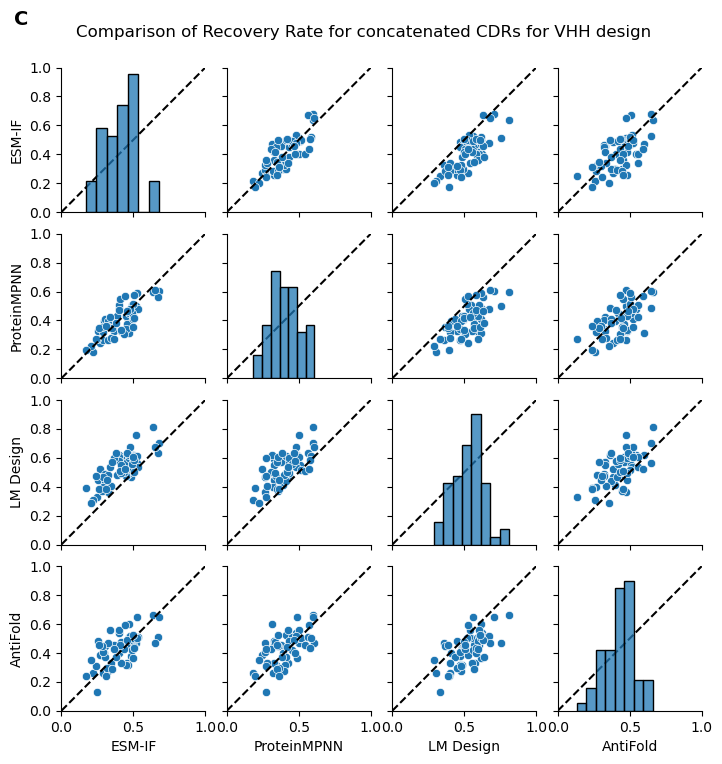

Ploting for similarity_B62-cdr_concat
Comparison of BLOSM62 Similarity for concatenated CDRs for VHH design


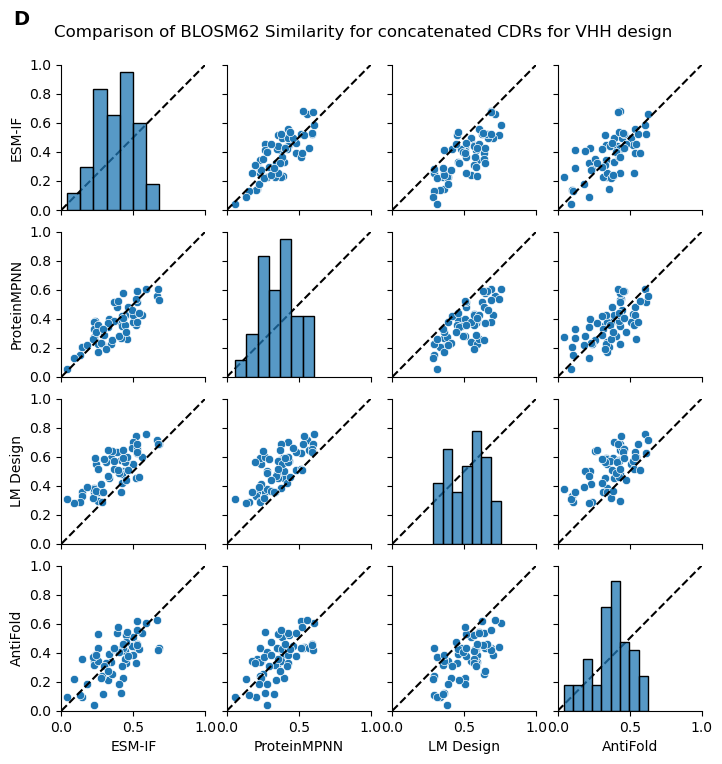

In [40]:
pair_plot_different_methods(df_pos_all, Design_methods.design_methods_vhh_1, antibody_type='vhh')

### relax

In [42]:

def pair_plot_different_methods4(df_pos_all, methods, antibody_type, using_method_name=True, fig_lab="AB", model="ESM-IF"):
    _df_pdb_all = df_pdb_all[df_pdb_all['task_id'].isin(methods)]
    _df_pdb_all['model'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]
    # print(_df_pdb_all.head())


    metrics = ['similarity_B62-cdr_concat', 'similarity_B62-H_CDR3']
    metrics_labels = ['Concatenated CDRs', 'H3']
    for i, metric in enumerate(metrics):

        df_merge = merge_df_pdb(_df_pdb_all, metric, design_methods=methods, using_method_name = using_method_name)
        print(f'Ploting for {metric}')
        df_merge = df_merge.drop(columns=["pdb_name"])
        df_merge.columns = ['Relax+' if 'relaxed' in col else 'Relax-' for col in df_merge.columns]

        # fig, axes = plt.subplots(5, 3, figsize=(12, 20))
        plt.figure(figsize=(4, 4))
        g = sns.scatterplot(data=df_merge, x="Relax-", y="Relax+")


        # for ax in g.axes.flatten():
        g.set_xlim(0, 1)
        g.set_ylim(0, 1)
        g.plot([0, 1], [0, 1], 'k--')
        

        print(f"Comparison of {metric_map[metric]} for {antibody_type_map[antibody_type]} design")

        g.figure.suptitle(f"{metrics_labels[i]} design with {model}", y=0.95, fontsize=10)
        plt.text(-0.02, 0.94, fig_lab[i], transform=g.figure.transFigure, fontsize=14, fontweight='bold')
        # g.figure.subplots_adjust(hspace=0.15, wspace=0.15)
        # g.figure.set_size_inches(7, 7)
    
    plt.show()

Ploting for similarity_B62-cdr_concat
Comparison of BLOSM62 similarity for concatenated CDRs for Fab design
Ploting for similarity_B62-H_CDR3
Comparison of BLOSM62 similarity for H3 for Fab design


/tmp/ipykernel_45259/1956103750.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pdb_all['model'] = [exps.exp_info[k]['NAME'] for k in _df_pdb_all['task_id']]


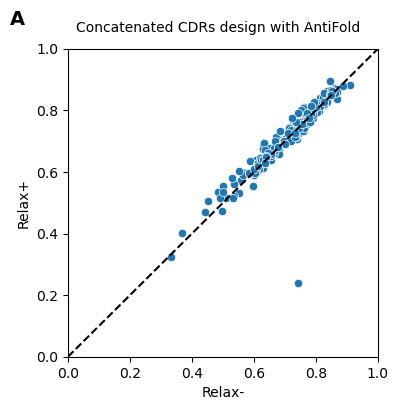

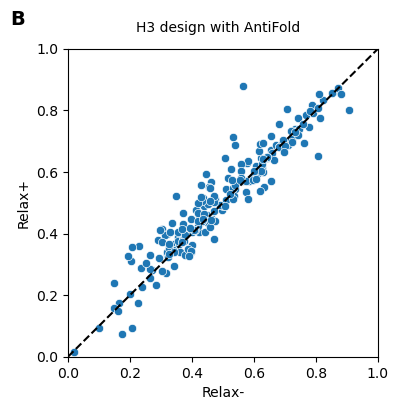

In [43]:
# pair_plot_different_methods(df_pos_all, Design_methods.antifold_relax, using_method_name=False, antibody_type='fab')
pair_plot_different_methods4(df_pos_all, Design_methods.antifold_relax, using_method_name=False, antibody_type='fab', fig_lab="AB", model="AntiFold")

## AA group analysis

### collect RDE, SASA, concat information

In [44]:
AA_GROUP_INFO_DICT = {
    'RDE_vhh': "../data/processed/df_RDE_vhh.csv",
    'RDE_fab': "../data/processed/df_RDE_fab.csv",
    'sasa_fab': "../data/processed/df_sasa_fab.csv",
    'sasa_vhh': "../data/processed/df_sasa_vhh.csv",
    'sasa_fab2': "../data/processed/df_sasa_fab2.csv",
    'sasa_vhh2': "../data/processed/df_sasa_vhh2.csv"
    }


In [45]:
class Process_AA_Group2:
    def __init__(self, info_dict, antibody_type='fab'):
        
        # self.df_RDE_vhh = pd.read_csv(info_dict['RDE_vhh'], index_col=0)
        if antibody_type == 'fab':
            self.df_RDE = pd.read_csv(info_dict['RDE_fab'], index_col=0)
            self.df_sasa = pd.read_csv(info_dict['sasa_fab2'])
        else:
            self.df_RDE = pd.read_csv(info_dict['RDE_vhh'], index_col=0)
            self.df_sasa = pd.read_csv(info_dict['sasa_vhh2'])

        self.collect_aa_group_info()


    def parse_for_res_group(self):

        df = self.df_info
        buried_cutoff = 0.1
        RDE_score_cutoff = 1.3
        delta_relative_cutoff = 0.4
        delta_total_cutoff = 60
        df.loc[df['relative_apo'] < buried_cutoff, 'group'] = 'buried'
        # df.loc[(df['RDE_score'] > RDE_score_cutoff) & (df['group'].isna()), 'group'] = 'key_interaction'
        df.loc[(df['delta_relative'] > delta_relative_cutoff) & (df['group'].isna()), 'group'] = 'key_interaction'
        df.loc[(df['delta_total'] > delta_total_cutoff) & (df['group'].isna()) , 'group'] = 'key_interaction'
        df.loc[(df['ag_concat'] == 1) & (df['group'].isna()), 'group'] = 'surface_contact'
        df.loc[df['group'].isna(), 'group'] = 'surface_no_contact'

        self.df_info = df

    def collect_aa_group_info(self):
        df_RDE = self.df_RDE
        df_sasa = self.df_sasa
        df_sasa['hash_id'] = df_sasa['pdb_name'] + df_sasa['chain'] + df_sasa['pos'].astype(str)
        df_sasa['delta_relative'] = df_sasa['relative_apo'] - df_sasa['relative_holo']
        df_sasa['delta_total'] = df_sasa['total_apo'] - df_sasa['total_holo']

        df_RDE['chain'] =  [mut[1] for mut in df_RDE['mutation_token']]
        df_RDE['hash_id'] = df_RDE['pdb'] + df_RDE['chain'] + df_RDE['res_idx'].astype(str)
        df_RDE = df_RDE[['hash_id', 'RDE_score']]

        self.df_info = pd.merge(df_sasa, df_RDE, on='hash_id')

        self.parse_for_res_group()

In [46]:
class Process_AA_Group:
    def __init__(self, info_dict, antibody_type='fab'):
        
        # self.df_RDE_vhh = pd.read_csv(info_dict['RDE_vhh'], index_col=0)
        if antibody_type == 'fab':
            self.df_RDE = pd.read_csv(info_dict['RDE_fab'], index_col=0)
            self.df_sasa = pd.read_csv(info_dict['sasa_fab'])
        else:
            self.df_RDE = pd.read_csv(info_dict['RDE_vhh'], index_col=0)
            self.df_sasa = pd.read_csv(info_dict['sasa_vhh'])

        self.collect_aa_group_info()


    def parse_for_res_group(self):

        df = self.df_info
        buried_cutoff = 0.2
        RDE_score_cutoff = 1.3
        df.loc[df['relative'] < buried_cutoff, 'group'] = 'buried'
        df.loc[(df['RDE_score'] > RDE_score_cutoff) & (df['group'].isna()), 'group'] = 'key_interaction'
        df.loc[(df['ag_concat'] == 1) & (df['group'].isna()), 'group'] = 'surface_contact'
        df.loc[df['group'].isna(), 'group'] = 'surface_no_contact'

        self.df_info = df

    def collect_aa_group_info(self):
        df_RDE = self.df_RDE
        df_sasa = self.df_sasa
        df_sasa['hash_id'] = df_sasa['pdb_name'] + df_sasa['chain'] + df_sasa['pos'].astype(str)

        df_RDE['chain'] =  [mut[1] for mut in df_RDE['mutation_token']]
        df_RDE['hash_id'] = df_RDE['pdb'] + df_RDE['chain'] + df_RDE['res_idx'].astype(str)
        df_RDE = df_RDE[['hash_id', 'RDE_score']]

        self.df_info = pd.merge(df_sasa, df_RDE, on='hash_id')

        self.parse_for_res_group()

## Different group of residues

In [62]:
def cal_identity(row):
    wt_aa = row['wt_aa']
    return row[wt_aa]/sum([1*row[aa] for aa in aa_list])

def cal_blosm62_sim(row):
    wt_aa = row['wt_aa']*sum([1*row[aa] for aa in aa_list])
    design_aa = "".join([aa*row[aa] for aa in aa_list])
    return calculate_seq_similarity_blosum62(wt_aa, design_aa, BLOSUM62_MATRIX)/100

def merge_df_pdb_aa_group(df_pos_all, design_methods, df_concat_info, scheme = 'methods'):
    
    dfs, recs, blos, aa_gps, methods, antigen_info  = [], [], [], [], [], []
    for k in design_methods:
        df_pos = df_pos_all[df_pos_all['task_id'] == k]
 
        df_pos['identity'] = df_pos.apply(cal_identity, axis=1)
        df_pos['blosm62'] = df_pos.apply(cal_blosm62_sim, axis=1)

        df_pos['chain'] = [cdr.split('_')[0] for cdr in df_pos['cdr']]
        df_pos['hash_id'] = df_pos['pdb_name'] + df_pos['chain'] + df_pos['pos'].astype(str)
        df_merge = pd.merge(df_pos, df_concat_info, on='hash_id')

        groups = ['buried', 'key_interaction', 'surface_contact',  'surface_no_contact']
        for aa_group in groups:
            df_merge_group = df_merge[df_merge['group'] == aa_group]

            all_wt_res = "".join(df_merge_group['wt_aa'])
            blosm62 = df_merge_group['blosm62'].sum()/ calculate_seq_similarity_blosum62(all_wt_res, all_wt_res, BLOSUM62_MATRIX)
            recovery = df_merge_group['identity'].mean()

            recs.append(recovery)
            blos.append(blosm62)
            aa_gps.append(aa_group)
            methods.append(exps.exp_info[k]['NAME'])
            if scheme == 'ag_no_ag':
                if "noAG" in k:
                    antigen_info.append("Ag-")
                else:
                    antigen_info.append("Ag+")

    df_all = pd.DataFrame({
        'methods': methods,
        'recovery': recs,
        'blosm62': blos,
        'aa_group': aa_gps
    })
    if scheme == 'ag_no_ag':
        df_all['Antigen Info'] = antigen_info
    dfs.append(df_all)
    
    return pd.concat(dfs, ignore_index=True)

In [63]:
aa_gp_fab = Process_AA_Group(AA_GROUP_INFO_DICT)
df_concat_info_fab = aa_gp_fab.df_info

df_group_fab = merge_df_pdb_aa_group(df_pos_all, Design_methods.design_methods_fab_1, df_concat_info_fab)
df_group_fab = df_group_fab[df_group_fab['aa_group']!='surface_no_contact']

aa_gp_vhh = Process_AA_Group2(AA_GROUP_INFO_DICT, antibody_type='vhh')
df_concat_info_vhh = aa_gp_vhh.df_info
df_group_vhh = merge_df_pdb_aa_group(df_pos_all, Design_methods.design_methods_vhh_1, df_concat_info_vhh)
df_group_vhh = df_group_vhh[df_group_vhh['aa_group']!='surface_no_contact']

df_group_vhh['antibody_type'] = 'VHH'
df_group_fab['antibody_type'] = 'Fab'

df_group_fab_vhh = pd.concat([df_group_vhh, df_group_fab], ignore_index=True)
df_group_fab_vhh = df_group_fab_vhh.rename(columns = {
    'aa_group': 'Amino Acid Group'
})

/tmp/ipykernel_45259/2578227617.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'buried' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['relative'] < buried_cutoff, 'group'] = 'buried'
/tmp/ipykernel_45259/1915781267.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['identity'] = df_pos.apply(cal_identity, axis=1)
/tmp/ipykernel_45259/1915781267.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [64]:
df_group_fab_vhh['Amino Acid Group'] = df_group_fab_vhh['Amino Acid Group'].map({
    "buried" : "Buried",
    "key_interaction" : "Key Interaction",
    "surface_contact" : "Surface Contact",
})

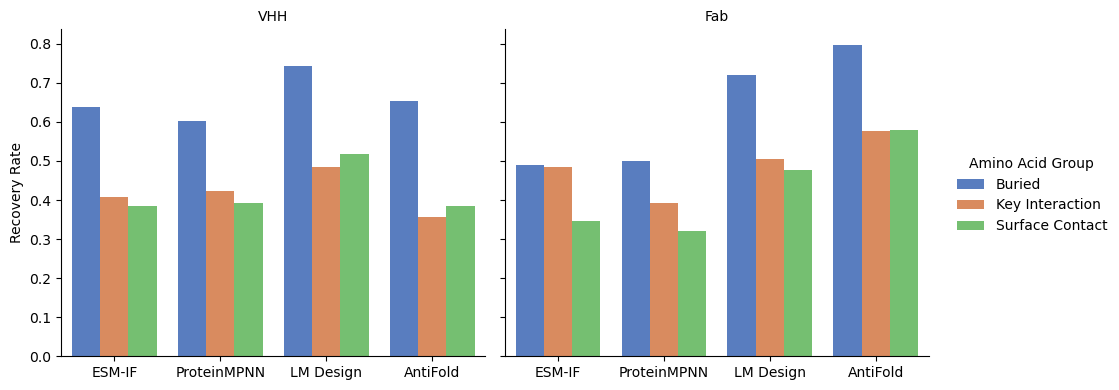

In [50]:


# fig, axes = plt.subplots(1, 1, figsize=(15, 5))
palette = sns.color_palette("muted", n_colors=df_group_fab_vhh['Amino Acid Group'].nunique())
g = sns.catplot(
    data=df_group_fab_vhh,
    y='recovery',
    x='methods',
    hue='Amino Acid Group',
    col='antibody_type',
    kind='bar',
    height=4,
    aspect=1.2,
    palette=palette,
)

g.set_axis_labels("", "Recovery Rate")
g.set_titles("{col_name}")
g.tight_layout()

plt.show()


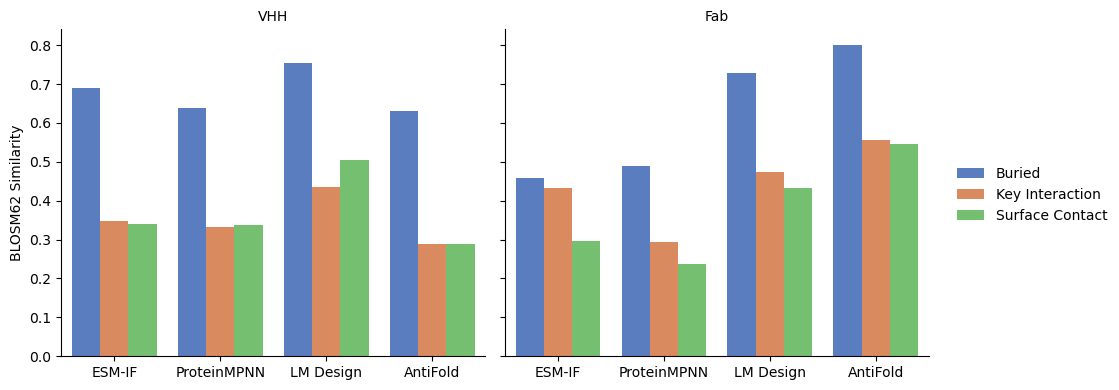

In [51]:


palette = sns.color_palette("muted", n_colors=df_group_fab_vhh['Amino Acid Group'].nunique())
g = sns.catplot(
    data=df_group_fab_vhh,
    y='blosm62',
    x='methods',
    hue='Amino Acid Group',
    col='antibody_type',
    kind='bar',
    height=4,
    aspect=1.2,
    palette=palette
)

g.set_axis_labels("", "BLOSM62 Similarity")
g.set_titles("{col_name}")
g.legend.set_title('')
g.tight_layout()
plt.savefig(f"../results/Fig-5-Sim.png", dpi=300, bbox_inches='tight')


plt.show()


### AA group for with and without antigen

In [77]:
aa_gp_fab = Process_AA_Group(AA_GROUP_INFO_DICT)
df_concat_info_fab = aa_gp_fab.df_info

df_group_fab = merge_df_pdb_aa_group(df_pos_all, Design_methods.ag_noag, df_concat_info_fab, scheme='ag_no_ag')
df_group_fab = df_group_fab[df_group_fab['aa_group']!='surface_no_contact']


df_group_fab = df_group_fab.rename(columns = {
    'aa_group': 'Amino Acid Group'
})

df_group_fab['Amino Acid Group'] = df_group_fab['Amino Acid Group'].map({
    "buried" : "Buried",
    "key_interaction" : "Key Interaction",
    "surface_contact" : "Surface Contact",
})


/tmp/ipykernel_45259/2578227617.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'buried' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['relative'] < buried_cutoff, 'group'] = 'buried'
/tmp/ipykernel_45259/1915781267.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['identity'] = df_pos.apply(cal_identity, axis=1)
/tmp/ipykernel_45259/1915781267.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

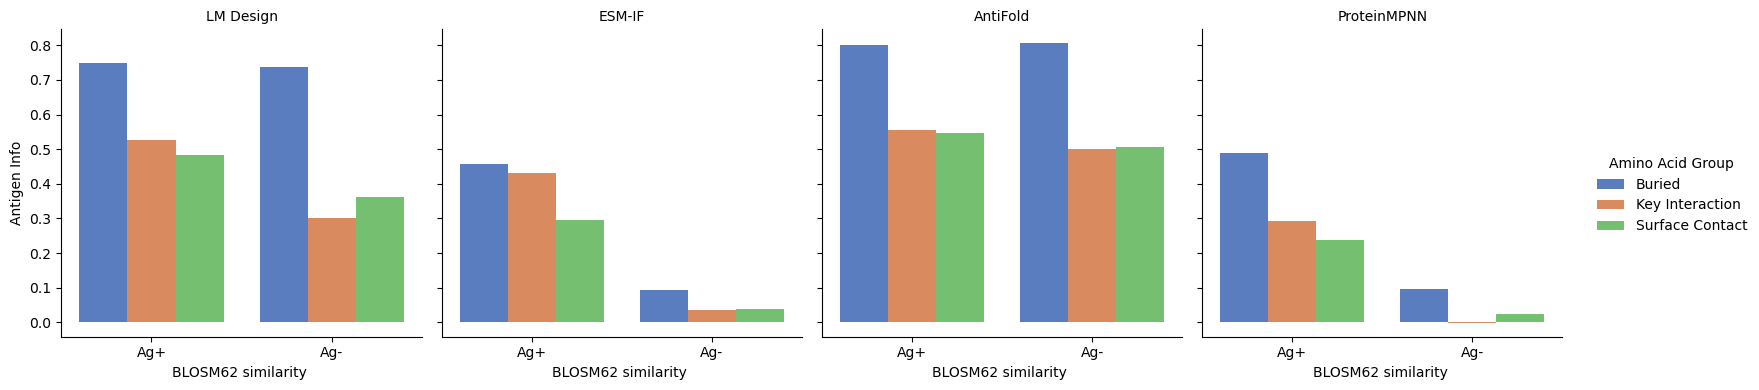

In [78]:


palette = sns.color_palette("muted", n_colors=df_group_fab['Amino Acid Group'].nunique())

g = sns.catplot(
    data=df_group_fab,
    y='blosm62',
    x='Antigen Info',
    hue='Amino Acid Group',
    col='methods',
    kind='bar',
    height=4,
    aspect=1,
    palette=palette
)

g.set_axis_labels("BLOSM62 similarity ", "Antigen Info")
g.set_titles("{col_name}")
g.tight_layout()

plt.show()


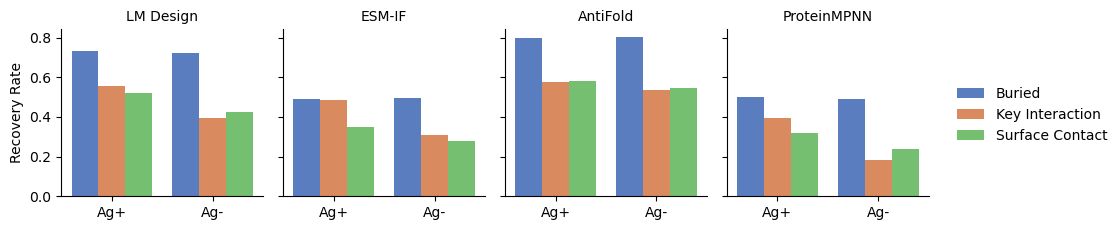

In [79]:


palette = sns.color_palette("muted", n_colors=df_group_fab['Amino Acid Group'].nunique())
# plt.figure(figsize=(8, 3))
# g.fig.set_size_inches(8, 3)

g = sns.catplot(
    data=df_group_fab,
    y='recovery',
    x='Antigen Info',
    hue='Amino Acid Group',
    col='methods',
    kind='bar',
    height=3*0.8,
    aspect=1,
    palette=palette
)

g.set_axis_labels("", "Recovery Rate")
g.set_titles("{col_name}")
g.legend.set_title('')
g.tight_layout()
plt.savefig(f"../results/Fig-6.png", dpi=300, bbox_inches='tight')
# 
plt.show()


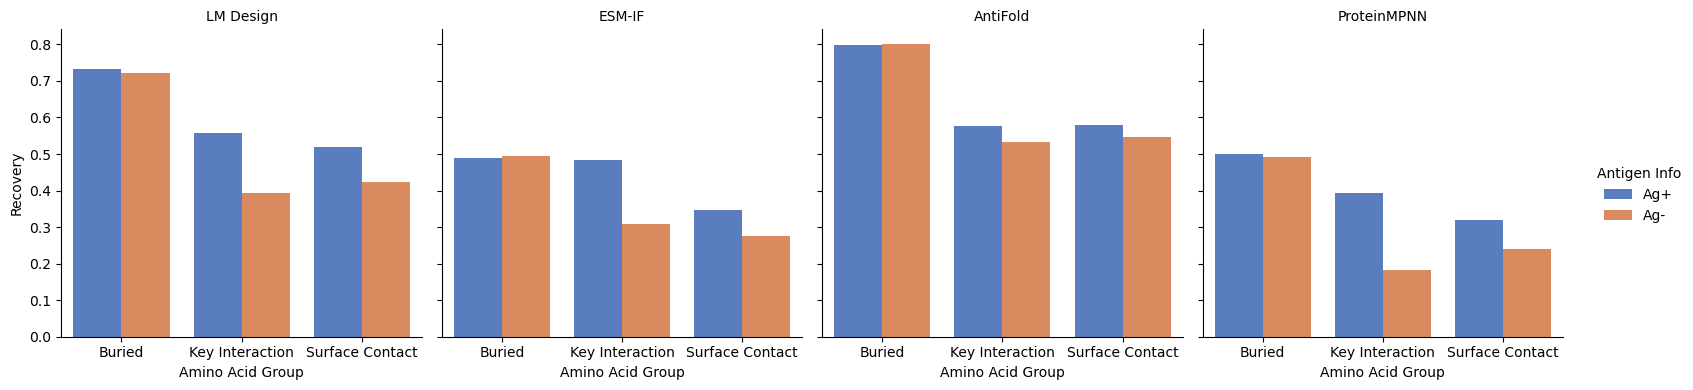

In [80]:

palette = sns.color_palette("muted", n_colors=df_group_fab['Antigen Info'].nunique())

g = sns.catplot(
    data=df_group_fab,
    y='recovery',

    hue='Antigen Info',
    x='Amino Acid Group',
    col='methods',
    kind='bar',
    height=4,
    aspect=1,
    palette=palette
)

g.set_axis_labels("Amino Acid Group", "Recovery")
g.set_titles("{col_name}")
g.tight_layout()

plt.show()


 ### aa bias

In [84]:
import matplotlib.ticker as ticker

def plot_aa_freqs4(df_pos_all, design_methods_fab, design_methods_vhh):

    palette = sns.color_palette("muted", len(design_methods_fab))
    
    fig, axes = plt.subplots(2, 2, figsize=(7, 7), sharey=True, sharex=True)
    axes_flat = axes.flatten()


    for i, (fab, vhh) in enumerate(zip(design_methods_fab, design_methods_vhh)):
        dfs = []
        for method in (fab, vhh):
            print(method)
            df_pos = df_pos_all[df_pos_all['task_id'] == method]

            df_wt = pd.DataFrame(Counter(df_pos['wt_aa'].values).items())
            df_wt.columns = ['aa', 'wt']
            df_wt['wt'] = df_wt['wt']/df_wt['wt'].sum()

            design_freq = df_pos[restype_1to3.keys()].sum(axis=0)
            design_freq = design_freq/design_freq.sum()
            df_design = pd.DataFrame(design_freq)

            df_design.columns = ['predicted_aa_freq']
            df_design['aa'] = df_design.index
            df_design['Design Method'] = method

            df_merge = pd.merge(df_wt, df_design, on='aa')
            if 'fab' in method:
                df_merge['Type'] = 'Fab'
            else:
                df_merge['Type'] = 'VHH'
            dfs.append(df_merge)
        
        df_concat = pd.concat(dfs)

        ax = axes_flat[i]
        

        sns.scatterplot(data=df_concat, x='wt', y='predicted_aa_freq', ax=ax, color=palette[i], hue='Type')
        
        for index, row in df_concat.iterrows():
            ax.annotate(row['aa'], (row['wt'], row['predicted_aa_freq']))
        

        ax.plot([0, 0.2], [0, 0.2], 'k--')


        ax.set_title(f"{exps.exp_info[method]['NAME']}")


        ax.set_xlim(0, 0.2)
        ax.set_ylim(0, 0.2)
        ax.legend(title='')

        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
        
        ax.set_ylabel('Design AA frequency')
        ax.set_xlabel('WT AA frequency')

    plt.tight_layout()
    plt.savefig(f"../results/Fig-4.png", dpi=300, bbox_inches='tight')  # bbox_inches='tight'

    plt.show()


esm_if-fab-fullseq
esm_if-vhh-fullseq
mpnn-fab-fullseq
mpnn-vhh-fullseq
lm_design_vanilla-fab-fullseq
lm_design_vanilla-vhh-fullseq
antifold-fab-fullseq
antifold-vhh-fullseq


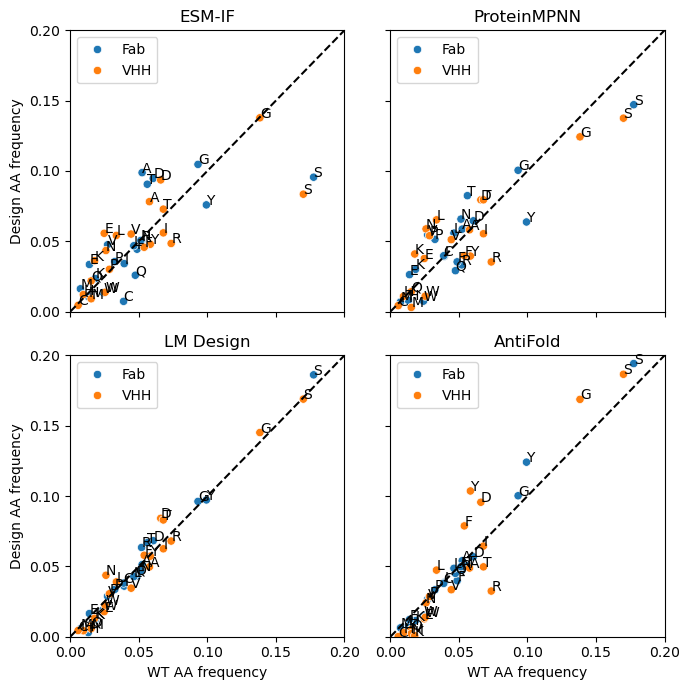

In [85]:
plot_aa_freqs4(df_pos_all, Design_methods.design_methods_fab_1, Design_methods.design_methods_vhh)

## Printing groupby score

In [97]:
df_method_summary = pd.read_csv("../data/processed/method_summary.csv")
# plot_dual_axis(df_method_summary)

df_method_summary = df_method_summary.rename(columns = {
    "BLOSM62 similarity for Fab CDRs": "Fab CDR design similarity",
    "BLOSM62 similarity for VHH CDRs": "VHH CDR design similarity",
    "Mutation effect corelation": "Mutation fitness prediction"
})

In [90]:
def plot_dual_axis2(df):

    palette = sns.color_palette("muted", 3)
    

    df_long = df.melt(id_vars=['Design_method'], 
                      value_vars=['Fab CDR design similarity', 'VHH CDR design similarity', 'Mutation fitness prediction'],
                      var_name='Metric', value_name='Value')


    fig, ax1 = plt.subplots(figsize=(8, 6))

    sns.barplot(data=df_long, x='Design_method', y='Value', hue='Metric', ax=ax1, palette=palette)

    ax1.set_ylabel('CDR design similarity / Mutation fitness predictioin corelation')
    ax1.set_xlabel('Design Method')
    ax1.set_ylim(0, 0.8)

    ax1.legend(title='')


    plt.title('Summary of Key Metrics for Inverse Folding Design Models')


    plt.tight_layout()
    plt.show()


  Design_method  Fab CDR design similarity  VHH CDR design similarity  \
0        ESM-IF                   0.422630                   0.376484   
1   ProteinMPNN                   0.348586                   0.362430   
2     LM Design                   0.596731                   0.512645   
3      AntiFold                   0.703239                   0.367971   

   Mutation fitness prediction  Design_method_numeric  
0                     0.453520                      1  
1                     0.398720                      3  
2                     0.363997                      2  
3                     0.199259                      0  
here


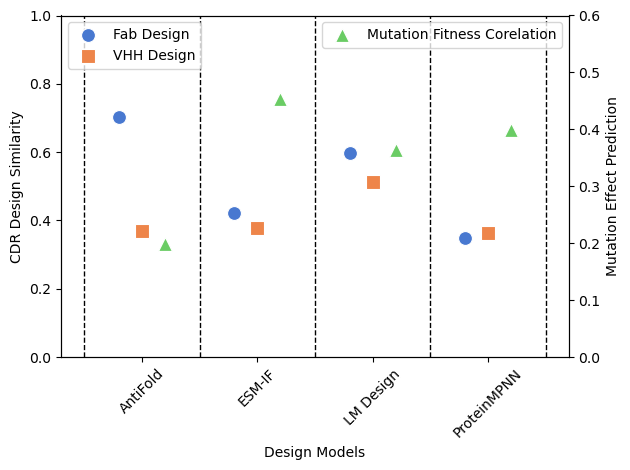

In [91]:

def plot_dual_axis_00(df):
    from sklearn.preprocessing import LabelEncoder


    encoder = LabelEncoder()
    df['Design_method_numeric'] = encoder.fit_transform(df['Design_method'])
    print(df)


    df['x_offset'] = df['Design_method_numeric']
    df['x_offset_1'] = df['Design_method_numeric'] - 0.2
    df['x_offset_2'] = df['Design_method_numeric']
    df['x_offset_3'] = df['Design_method_numeric'] + 0.2


    palette = sns.color_palette("muted", 3)
    fig, ax1 = plt.subplots(figsize=(8*0.8, 6*0.8))

    sns.scatterplot(data=df, x='x_offset_1', y='Fab CDR design similarity', ax=ax1, label='Fab Design', color=palette[0], s=100, marker='o')
    sns.scatterplot(data=df, x='x_offset_2', y='VHH CDR design similarity', ax=ax1, label='VHH Design', color=palette[1], s=100, marker='s')

    ax1.set_ylabel('CDR Design Similarity')
    ax1.set_xlabel('Design Models')
    ax1.set_xticks(df['x_offset'])
    ax1.set_xticklabels(encoder.inverse_transform(df['Design_method_numeric']), rotation=45)
    ax1.set_ylim(0, 1)
    ax1.legend(loc='upper left')

    for i in range(0, len(df['x_offset'])):

        ax1.axvline(x=df['x_offset'].iloc[i] - 0.5, color='black', linestyle='--', linewidth=1)

        if df['x_offset'].iloc[i] == 3: # at the very bundary of the figure
            print("here")
            ax1.axvline(x=df['x_offset'].iloc[i] + 0.5, color='black', linestyle='--', linewidth=1)




    ax2 = ax1.twinx()
    sns.scatterplot(data=df, x='x_offset_3', y='Mutation fitness prediction', ax=ax2, label='Mutation Fitness Corelation', color=palette[2], s=100, marker='^')
    ax2.set_ylabel('Mutation Effect Prediction')
    ax2.set_ylim(0, 0.6)
    
    plt.tight_layout()
    plt.show()


plot_dual_axis_00(df_method_summary)

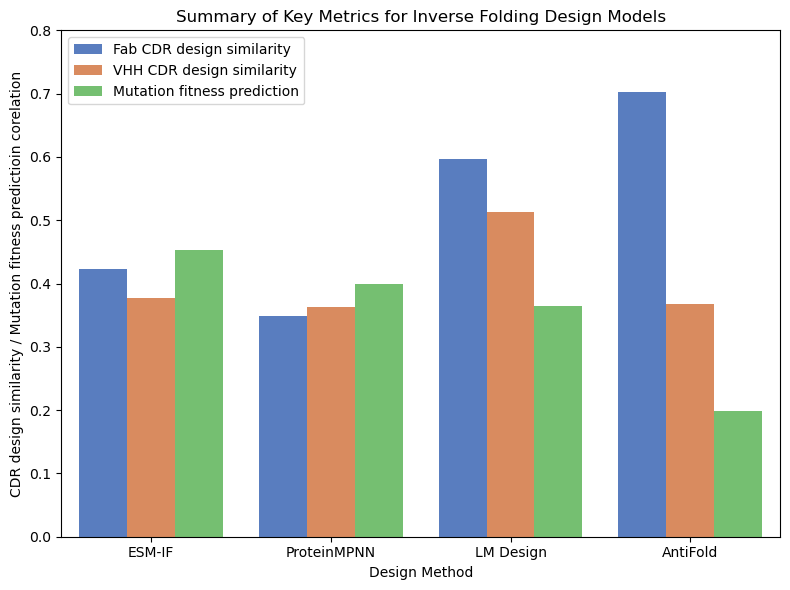

In [92]:
plot_dual_axis2(df_method_summary)

## Checking designs

In [95]:
import logomaker
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

def get_seq_slice(seq, idx):
    return "".join([seq[i-1] for i in idx])

def logo_plot_for_list(seq_list, wt_seq, idx):
    # start, end = cdr_dict['cdrh3'][0][0]-2, cdr_dict['cdrh3'][0][1]+2
    sub_alignment = seq_list
    # sub_alignment = [get_seq_slice(record, idx) for record in seq_list]
    alignment_df = logomaker.alignment_to_matrix(sub_alignment)
    fig, ax = plt.subplots(figsize=(len(idx)*0.55, 1.5))
    # plt.figure()
    logomaker.Logo(alignment_df, color_scheme="weblogo_protein", ax=ax)
    wt_labels = [f"{aa}{pos+1}" for pos, aa in zip(idx, wt_seq)]

    plt.xticks(range(len(wt_labels)), wt_labels)
    #print(file_path.split('/')[-1])
    
    plt.show()

def illustrate_designs(df_info_all, task_ids, pdb, plot_CDR_H = None, plot_CDR_L = None):

    # printing infomation of this pdb using the first task in the task_ids list, assuming it is for the same pdb
    task_id = task_ids[0]
    df_pdb = df_info_all[df_info_all['pdb_name'] == pdb]
    args = df_pdb[df_pdb['task_id'] == task_id]
    # print(args)
    assert len(args) == 1
    args = args.iloc[0]
    if pd.isna(args['vl_chain']):
        antibody_type = 'vhh'
    else:
        antibody_type = 'fab'
    method = exps.exp_info[task_id]['method']
    if_design = Inverse_Folding_Design(args, method = method, antibody_type = antibody_type)
    wt_seqs = get_sequence_by_biopython(args['pdb_path'])
    
    print(f"{task_id} - method: {method} for {if_design.pdb_name}")
    print(if_design.pdb_name)
    print(wt_seqs)
    print(if_design.cdr_range)
    print(if_design.cdr_seq)

    c = abnumber.Chain(if_design.wt_seq['H'], scheme='imgt')
    c.print_wide()
    c.print_tall()
    if antibody_type == 'fab':
        c = abnumber.Chain(if_design.wt_seq['L'], scheme='imgt')
        c.print_wide()
        c.print_tall()

    # generating logo plot for the indicated tasks
    for i, task_id in enumerate(task_ids):
        
        args = df_pdb[df_pdb['task_id'] == task_id]
        assert len(args) == 1
        args = args.iloc[0]

        method = exps.exp_info[task_id]['method']
        if_design = Inverse_Folding_Design(args, method = method, antibody_type = antibody_type)
        
        _cdrs = ['H_CDR1', 'H_CDR2', 'H_CDR3']
        if plot_CDR_H:
            _cdrs = plot_CDR_H
        _cdr_seqs = [f"seq-{cdr}" for cdr in _cdrs]

        _df = if_design.df_all_design.copy()

        _df['cdr_concat'] = _df[_cdr_seqs].agg(''.join, axis=1)

        _cdr_wt = ""
        for cdr in _cdrs:
            _cdr_wt += if_design.cdr_seq[cdr]

        _cdr_idx = []
        for cdr in _cdrs:
            _cdr_idx += if_design.cdr_pos[cdr]
        
        if i == 0:
            print(f"ploting for heavy chain - wt_seq")
            logo_plot_for_list([_cdr_wt]*100, _cdr_wt, _cdr_idx)

        print(f"ploting for heavy chain - {task_id}")
        logo_plot_for_list(_df['cdr_concat'], _cdr_wt, _cdr_idx)

    if antibody_type == 'fab':
        for i, task_id in enumerate(task_ids):
    
            args = df_pdb[df_pdb['task_id'] == task_id]
            assert len(args) == 1
            args = args.iloc[0]

            method = exps.exp_info[task_id]['method']
            if_design = Inverse_Folding_Design(args, method = method, antibody_type = antibody_type)

            _cdrs = ['L_CDR1', 'L_CDR2', 'L_CDR3']
            if plot_CDR_L:
                _cdrs = plot_CDR_L
            _cdr_seqs = [f"seq-{cdr}" for cdr in _cdrs]

            _df = if_design.df_all_design.copy()

            _df['cdr_concat'] = _df[_cdr_seqs].agg(''.join, axis=1)

            _cdr_wt = ""
            for cdr in _cdrs:
                _cdr_wt += if_design.cdr_seq[cdr]

            _cdr_idx = []
            for cdr in _cdrs:
                _cdr_idx += if_design.cdr_pos[cdr]

            if i == 0:
                print(f"ploting for light chain - wt_seq")
                logo_plot_for_list([_cdr_wt]*100, _cdr_wt, _cdr_idx)

            print(f"ploting for light chain - {task_id}")
            logo_plot_for_list(_df['cdr_concat'], _cdr_wt, _cdr_idx)





In [93]:
pdb = "8tfl_B-HL"
df = df_pdb_all[df_pdb_all['pdb_name'] == pdb]
df[df['task_id'].isin(Design_methods.design_methods_fab)]

identity-cdr_concat  similarity_B62-cdr_concat  identity-H_CDR1  \
776              0.557647                   0.537363         0.904286   
1385             0.677255                   0.667945         0.892857   
1991             0.434118                   0.450068         0.461429   
2600             0.372353                   0.338425         0.298571   
2803             0.633725                   0.631678         0.998571   

      identity-H_CDR2  identity-H_CDR3  similarity_B62-H_CDR1  \
776          0.606667         0.367500               0.948205   
1385         0.661667         0.442500               0.940000   
1991         0.528333         0.346667               0.464103   
2600         0.505000         0.309167               0.270000   
2803         0.503333         0.406667               0.999231   

      similarity_B62-H_CDR2  similarity_B62-H_CDR3  hydropathy-H_CDR1  \
776                0.688485               0.273462          -0.351571   
1385               0.717273               0.420769          -0.542429   
1991               0.599697               0.386154          -0.421714   
2600               0.600303               0.304103           0.035000   
2803               0.727576               0.393462          -0.357000   

      hydropathy-H_CDR2  ...  similarity_B62-L_CDR2  similarity_B62-L_CDR3  \
776           -0.632167  ...               0.378919                 0.4588   
1385          -0.136833  ...               0.856216                 0.6800   
1991          -0.636333  ...               0.514865                 0.2812   
2600          -0.948167  ...               0.339459                 0.3672   
2803          -1.298167  ...               0.634865                 0.5852   

      hydropathy-L_CDR1  hydropathy-L_CDR2  hydropathy-L_CDR3  \
776           -0.899364          -1.272429          -1.040750   
1385          -0.511273          -0.324000          -0.775000   
1991          -0.834727          -1.577143          -0.278375   
2600          -0.312727           0.169000          -1.012625   
2803          -0.565364          -0.579000          -1.011875   

      hydropathy_wt-L_CDR1  hydropathy_wt-L_CDR2  hydropathy_wt-L_CDR3  \
776              -0.945455             -0.685714               -0.6875   
1385             -0.945455             -0.685714               -0.6875   
1991             -0.945455             -0.685714               -0.6875   
2600             -0.945455             -0.685714               -0.6875   
2803             -0.945455             -0.685714               -0.6875   

                            task_id   pdb_name  
776   lm_design_vanilla-fab-fullseq  8tfl_B-HL  
1385           antifold-fab-fullseq  8tfl_B-HL  
1991             esm_if-fab-fullseq  8tfl_B-HL  
2600               mpnn-fab-fullseq  8tfl_B-HL  
2803             abmpnn-fab-fullseq  8tfl_B-HL  

[5 rows x 28 columns]

esm_if-fab-fullseq - method: esm_if for 8tfl_B-HL
8tfl_B-HL
{'A': 'DVCMDPEPIVRIVGRNGLCVDVRDGRFHNGNAIQLWPCKSNTDANQLWTLKRDNTIRSNGKCLTTYGYSPGVYVMIYDCNTAATDATRWQIWDNGTIINPRSSLVLAATSGNSGTTLTVQTNIYAVSQGWLPTNNTQPFVTTIVGLYGLCLQANSGQVWIEDCSSEKAEQQWALYADGSIRPQQNRDNCLTSDSNIRETVVKILSCGPASSGQRWMFKNDGTILNLYSGLVLDVRASDPSLKQIILYPLHGDPNQIWLPLF', 'H': 'QVQLQQSGAELMKPGASVKISCKSTGYTFSSYWIEWIKQRPGHGLEWIGEIFPGSGSINYNEKFKGKATFTADTSSNTAYMQLSSLTFEDSAVYYCARWDGNDFHNTMDYWGQGTSVTVSS', 'L': 'DIVMTQSPSSLSASLGGRVTITCKASQDIKKYIGWYQHRPGKGPRLLIHYTSTLQPGIPSRFSGGGSGRDYSFNISNLEPEDIATYYCLQYDHLWTFGGGTKLEIK'}
{'H_CDR1': range(26, 32), 'H_CDR2': range(52, 57), 'H_CDR3': range(99, 110), 'L_CDR1': range(24, 34), 'L_CDR2': range(50, 56), 'L_CDR3': range(89, 96)}
{'H_CDR1': 'GYTFSSY', 'H_CDR2': 'FPGSGS', 'H_CDR3': 'WDGNDFHNTMDY', 'L_CDR1': 'KASQDIKKYIG', 'L_CDR2': 'YTSTLQP', 'L_CDR3': 'LQYDHLWT'}
QVQLQQSGAELMKPGASVKISCKSTGYTFSSYWIEWIKQRPGHGLEWIGEIFPGSGSINYNEKFKGKATFTADTSSNTAYMQLSSLTFEDSAVYYCARWDGNDFHNTMDYWGQGTSVTVSS
              

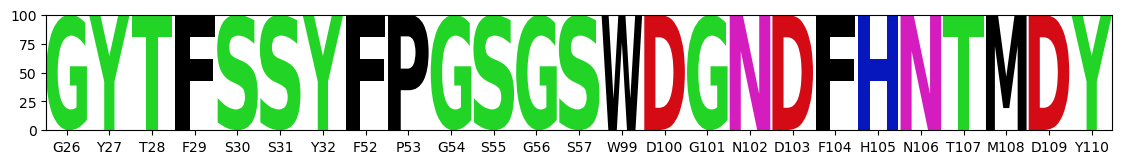

ploting for heavy chain - esm_if-fab-fullseq


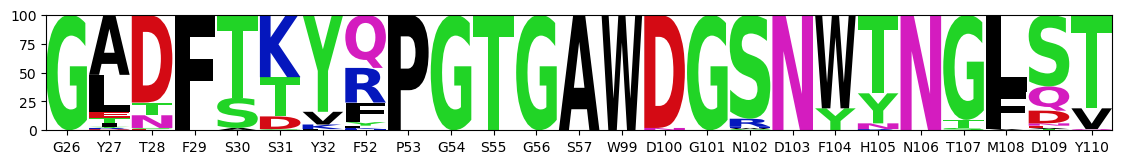

ploting for heavy chain - mpnn-fab-fullseq


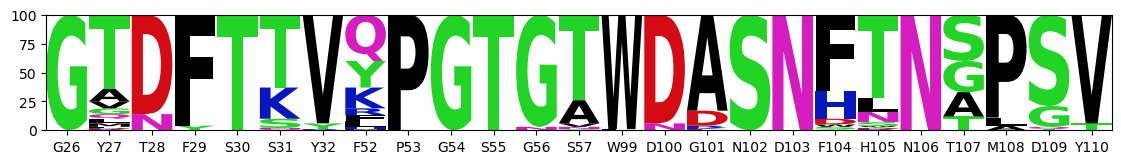

ploting for heavy chain - lm_design_vanilla-fab-fullseq


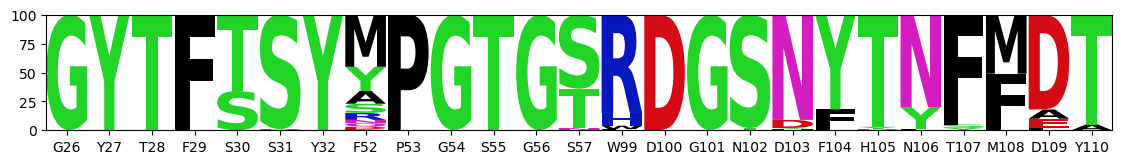

ploting for heavy chain - antifold-fab-fullseq


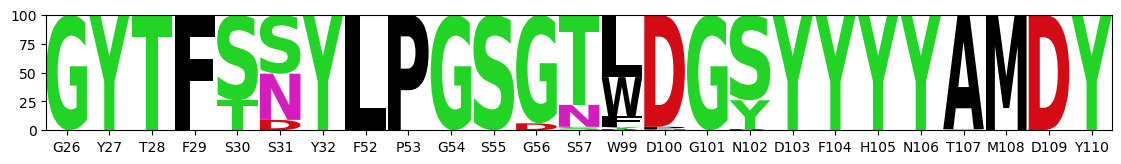

ploting for heavy chain - abmpnn-fab-fullseq


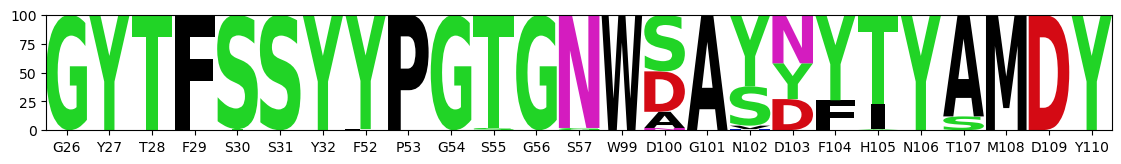

ploting for light chain - wt_seq


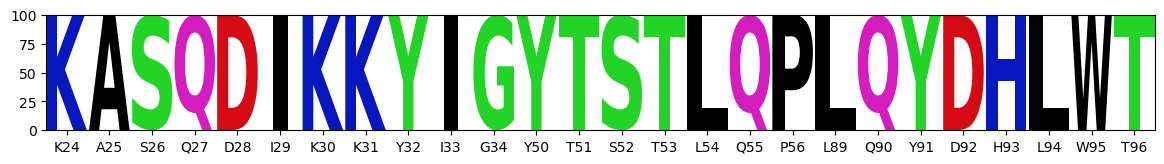

ploting for light chain - esm_if-fab-fullseq


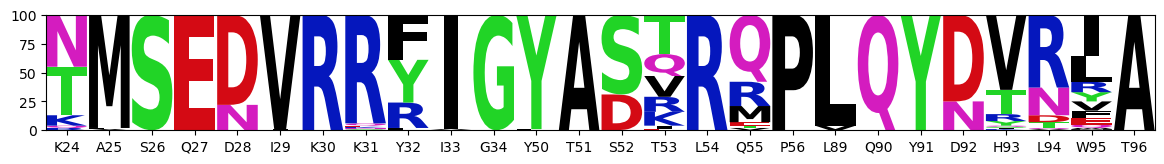

ploting for light chain - mpnn-fab-fullseq


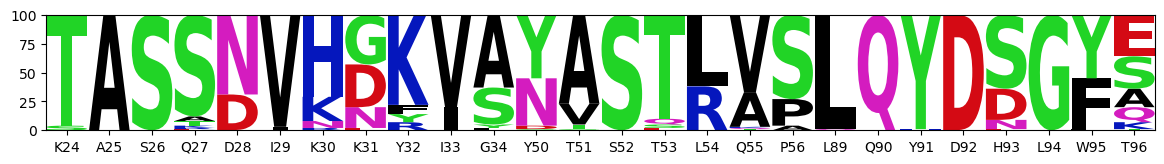

ploting for light chain - lm_design_vanilla-fab-fullseq


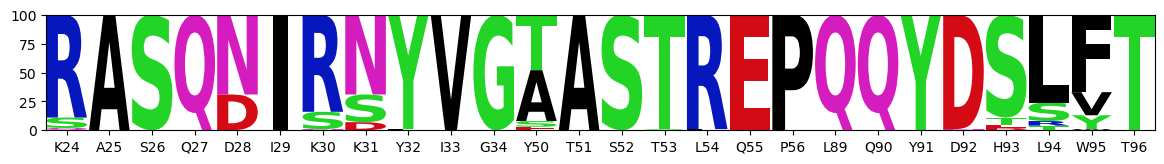

ploting for light chain - antifold-fab-fullseq


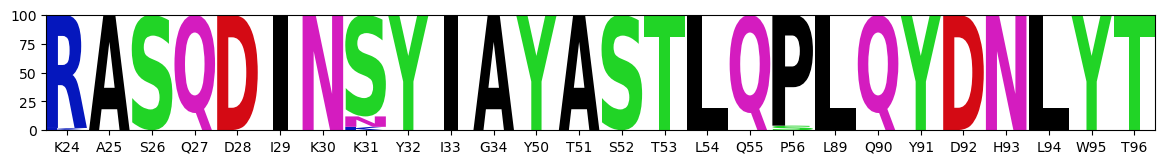

ploting for light chain - abmpnn-fab-fullseq


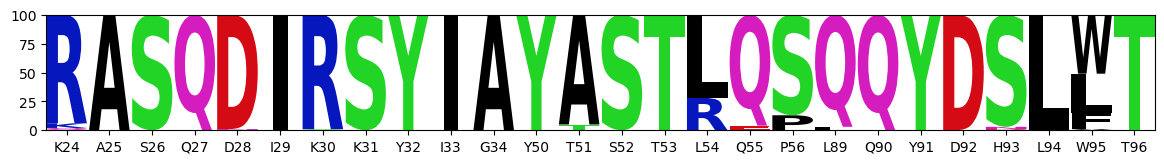

In [96]:
# pdb = "7yv1_A-HL"
task_id = 'esm_if-fab-fullseq'
# illustrate_designs(df_info_all, Design_methods.design_methods_fab, pdb, plot_CDR_H=['H_CDR3'])
illustrate_designs(df_info_all, Design_methods.design_methods_fab, pdb)